----
# **Import Libraries**

In [133]:
import math, pickle, os, ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# import opendatasets

%matplotlib inline

In [134]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [135]:
def outlier_thresholds(dataframe, variable):
    """
    Calculate the lower and upper limits for identifying outliers in a specified column of a DataFrame
    
    Parameters:
    - dataframe: pandas DataFrame containing the data
    - variable: string name of the column for which to calculate the outlier thresholds
    
    Returns:
    - A tuple containing the lower limit and upper limit for outliers in the specified column
    """
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def has_outliers(dataframe, variable):
    """
    Check if a specified column in a DataFrame contains any outliers based on calculated thresholds
    
    Parameters:
    - dataframe: pandas DataFrame containing the data
    - variable: string name of the column to check for outliers
    
    Returns:
    - None. Prints the column name followed by "yes" if outliers are found, otherwise prints "no"
    """
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    if dataframe[(dataframe[variable] < low_limit) | (dataframe[variable] > up_limit)].any(axis=None):
        print(variable, "yes")
    else:
        print(variable, "no")

def replace_with_thresholds(dataframe, column_names):
    """
    Replace outliers in specified columns of a DataFrame with their respective threshold values
    
    Parameters:
    - dataframe: pandas DataFrame containing the data.
    - column_names: list of string names of the columns in which to replace outliers
    
    Returns:
    - None. Modifies the DataFrame in place, replacing outliers with their respective threshold values
    """
    for column in column_names:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            low_limit, up_limit = outlier_thresholds(dataframe, column)
            dataframe.loc[dataframe[column] < low_limit, column] = low_limit
            dataframe.loc[dataframe[column] > up_limit, column] = up_limit
        else:
            print(f"Column '{column}' is not numeric and will be skipped.")

def remove_outliers(dataframe, column_names):
    """
    Remove rows from a DataFrame where specified columns contain outliers
    
    Parameters:
    - dataframe: pandas DataFrame containing the data.
    - column_names: list of string names of the columns to check for outliers
    
    Returns:
    - DataFrame with rows containing outliers in the specified columns removed
    """
    for column in column_names:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            low_limit, up_limit = outlier_thresholds(dataframe, column)
            dataframe = dataframe[(dataframe[column] >= low_limit) & (dataframe[column] <= up_limit)]
        else:
            print(f"Column '{column}' is not numeric and will be skipped.")
    return dataframe


In [136]:
def drop_columns_with_prefix(df, column_prefix):
    """
    Drop columns in the DataFrame that start with the specified prefix
    
    Parameters:
    - df: pandas DataFrame containing the data
    - column_prefix: string prefix to identify columns to be dropped
    
    Returns:
    - DataFrame with the specified columns dropped
    """
    columns_to_drop = df.filter(like=column_prefix, axis=1).columns

    df = df.drop(columns=columns_to_drop)
    
    return df

def process_columns_with_prefix(df, column_prefix):
    """
    Convert columns starting with column_prefix into lists,
    find concentration points for 'True' values, and calculate
    a decimal value representing the concentration points
    
    Parameters:
    - df: pandas DataFrame containing the data
    - column_prefix: string prefix to identify relevant columns
    
    Returns:
    - DataFrame with additional columns for concentration points
    """
    target_columns = [col for col in df.columns if col.startswith(column_prefix)]
    
    df['combined_list'] = df[target_columns].apply(lambda row: row.dropna().tolist(), axis=1)
    
    def calculate_true_concentration(item_list):
        if not item_list:
            return 0.0
        counter = Counter(item_list)
        true_count = counter.get(True, 0)
        total = sum(counter.values())
        concentration = true_count / total if total > 0 else 0.0
        return concentration
    
    df['concentration_points'] = df['combined_list'].apply(calculate_true_concentration)
    
    df = drop_columns_with_prefix(df, column_prefix)
    df.rename(columns={'combined_list': f'{column_prefix}combined_list', 'concentration_points': f'{column_prefix}concentration_points'}, inplace=True)
    
    return df

----
# **Preparing Datasets**

In [137]:
# opendatasets.download('https://www.kaggle.com/datasets/fronkongames/steam-games-dataset/data')

In [138]:
df = pd.read_csv('./steam-games-dataset/games.csv')

In [139]:
df.head()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.galacticbowling.net,NaN,NaN,True,False,False,0,NaN,0,6,11,NaN,30,0,NaN,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://trainbandit.com,NaN,support@rustymoyher.com,True,True,False,0,NaN,0,53,5,NaN,12,0,NaN,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,ramoncampiaof31@gmail.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://henosisgame.com/,https://henosisgame.com/,info@henosisgame.com,True,True,True,0,NaN,0,3,0,NaN,0,0,NaN,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://www.unusual-games.com/home/,https://www.unusual-games.com/contact/,welistentoyou@unusual-games.com,True,True,False,0,NaN,0,50,8,NaN,17,0,This Game may contain content not appropriate ...,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [140]:
df.tail()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
85098,2669080,Mannerheim's Saloon Car,"Jan 2, 2024",0 - 0,0,0,0.00,0,Marshal Mannerheim’s Saloon Car is the train c...,"['English', 'Finnish']",['Finnish'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,xgsmikkeli@gmail.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Xamk Game Studios,"Sodan ja rauhan keskus Muisti, Päämajamuseo","Single-player,Tracked Controller Support,VR Only","Adventure,Simulation",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
85099,2736910,Beer Run,"Jan 3, 2024",0 - 0,0,0,0.00,0,Beer Run is an Indie game created to steal bee...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,cperez955c@gmail.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,955 Games,955 Games,Single-player,"Casual,Indie",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
85100,2743220,My Friend The Spider,"Jan 4, 2024",0 - 0,0,0,0.00,0,A small 'horror' narrative game about isolatio...,['English'],['English'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,https://markleash.itch.io/my-friend-the-spider,NaN,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,MCA,MCA,Single-player,"Adventure,Simulation",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
85101,2293130,Path of Survivors,"Jan 8, 2024",0 - 0,0,0,3.99,0,Path of Survivors is a multi-class auto-battle...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://www.limitedinput.com/,https://www.limitedinput.com/contact,support@limitedinput.com,True,False,False,0,NaN,0,0,0,NaN,34,0,NaN,0,0,0,0,Limited Input,Limited Input,"Single-player,Steam Achievements,Partial Contr...","Action,Casual,Indie,RPG,Simulation",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
85102,2738840,The Night Heist,"Jan 5, 2024",0 - 0,0,0,9.99,0,"Meet Mariah, Maria, and Missy a group of colle...",['English'],['English'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://instagram.com/ladellparks,NaN,ladellparks@gmail.com,True,False,False,0,NaN,0,0,0,NaN,12,0,NaN,0,0,0,0,Ladell Parks,Ladell Parks,"Single-player,Steam Achievements,Full controll...","Casual,Indie",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


## **Delete unused column**

In [141]:
df.columns

Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')

In [142]:
col = ['Estimated owners', 'Peak CCU', 'DLC count', 'About the game', 'Reviews', 
       'Header image', 'Website', 'Support url', 'Support email', 'Metacritic score', 
       'Metacritic url', 'User score', 'Score rank', 'Achievements', 'Recommendations', 
       'Notes', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime two weeks',
       'Median playtime forever', 'Categories', 'Tags', 'Screenshots', 'Movies']

In [143]:
df = df.drop(columns=col, axis=1)

In [144]:
df

,AppID,Name,Release date,Required age,Price,Supported languages,Full audio languages,Windows,Mac,Linux,Positive,Negative,Developers,Publishers,Genres
0,20200,Galactic Bowling,"Oct 21, 2008",0,19.99,['English'],[],True,False,False,6,11,Perpetual FX Creative,Perpetual FX Creative,"Casual,Indie,Sports"
1,655370,Train Bandit,"Oct 12, 2017",0,0.99,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,False,53,5,Rusty Moyher,Wild Rooster,"Action,Indie"
2,1732930,Jolt Project,"Nov 17, 2021",0,4.99,"['English', 'Portuguese - Brazil']",[],True,False,False,0,0,Campião Games,Campião Games,"Action,Adventure,Indie,Strategy"
3,1355720,Henosis™,"Jul 23, 2020",0,5.99,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,True,3,0,Odd Critter Games,Odd Critter Games,"Adventure,Casual,Indie"
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0,0.00,"['English', 'Spanish - Spain']",[],True,True,False,50,8,Unusual Games,Unusual Games,"Adventure,Indie"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85098,2669080,Mannerheim's Saloon Car,"Jan 2, 2024",0,0.00,"['English', 'Finnish']",['Finnish'],True,False,False,0,0,Xamk Game Studios,"Sodan ja rauhan keskus Muisti, Päämajamuseo","Adventure,Simulation"
85099,2736910,Beer Run,"Jan 3, 2024",0,0.00,['English'],[],True,False,False,0,0,955 Games,955 Games,"Casual,Indie"
85100,2743220,My Friend The Spider,"Jan 4, 2024",0,0.00,['English'],['English'],True,False,False,0,0,MCA,MCA,"Adventure,Simulation"
85101,2293130,Path of Survivors,"Jan 8, 2024",0,3.99,['English'],[],True,False,False,0,0,Limited Input,Limited Input,"Action,Casual,Indie,RPG,Simulation"


## **Add Rating Column**

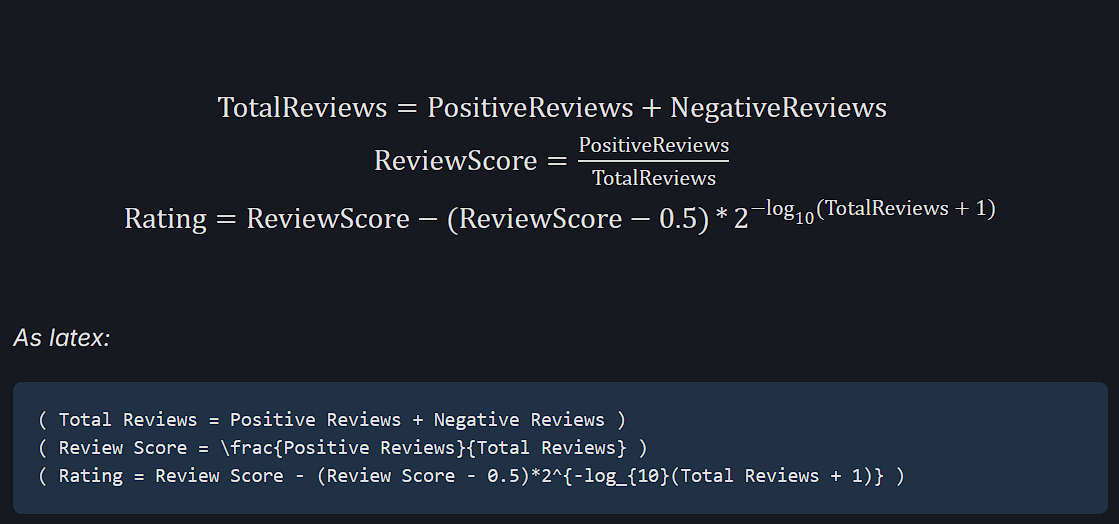

reference: https://steamdb.info/blog/steamdb-rating/

In [145]:
# Calculate game rating based on steamdb algorithm
TotalReviews = df['Positive'] + df['Negative']
ReviewScore = df['Positive']/TotalReviews
df.loc[:, 'Rating'] = (ReviewScore - (ReviewScore - 0.5) * (2 ** (-TotalReviews.apply(lambda x: math.log10(x + 1)))))

In [146]:
# round rating value
df['Rating'] = df['Rating'].round(2)

In [147]:
df = df.drop(columns=['Positive', 'Negative'], axis=0)

In [148]:
df.head()

,AppID,Name,Release date,Required age,Price,Supported languages,Full audio languages,Windows,Mac,Linux,Developers,Publishers,Genres,Rating
0,20200,Galactic Bowling,"Oct 21, 2008",0,19.99,['English'],[],True,False,False,Perpetual FX Creative,Perpetual FX Creative,"Casual,Indie,Sports",0.41
1,655370,Train Bandit,"Oct 12, 2017",0,0.99,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,False,Rusty Moyher,Wild Rooster,"Action,Indie",0.79
2,1732930,Jolt Project,"Nov 17, 2021",0,4.99,"['English', 'Portuguese - Brazil']",[],True,False,False,Campião Games,Campião Games,"Action,Adventure,Indie,Strategy",NaN
3,1355720,Henosis™,"Jul 23, 2020",0,5.99,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,True,Odd Critter Games,Odd Critter Games,"Adventure,Casual,Indie",0.67
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0,0.00,"['English', 'Spanish - Spain']",[],True,True,False,Unusual Games,Unusual Games,"Adventure,Indie",0.76


----
# **Pre Processing**

## **Handle NULL values**

In [149]:
df.isna().sum()

AppID                       0
Name                        6
Release date                0
Required age                0
Price                       0
Supported languages         0
Full audio languages        0
Windows                     0
Mac                         0
Linux                       0
Developers               3587
Publishers               3867
Genres                   3555
Rating                  21168
dtype: int64

In [150]:
# Drop NULL values
df = df.dropna()

In [151]:
df.isna().sum()

AppID                   0
Name                    0
Release date            0
Required age            0
Price                   0
Supported languages     0
Full audio languages    0
Windows                 0
Mac                     0
Linux                   0
Developers              0
Publishers              0
Genres                  0
Rating                  0
dtype: int64

In [152]:
df.shape

(63554, 14)

## **Release date**

In [153]:
# Convert the 'Release date' column to datetime using the format '%b %d, %Y' (e.g., Jan 01, 2023)
# If there are errors during the conversion, they will be set to NaT (Not a Time)
df['Release date'] = pd.to_datetime(df['Release date'], format='%b %d, %Y', errors='coerce')

# Create a mask identifying rows where the 'Release date' is null (NaT) after the initial conversion
month_year_mask = df['Release date'].isnull()

# For the rows identified by the mask, attempt to convert the 'Release date' again using the format '%b %Y' (e.g., Jan 2023)
# If conversion is successful, update these rows in the 'Release date' column
# If there are still errors during this conversion, fill those with the default date '1/1/1900'
df.loc[month_year_mask, 'Release date'] = pd.to_datetime(
    df.loc[month_year_mask, 'Release date'], 
    format='%b %Y', 
    errors='coerce'
).fillna(pd.to_datetime('1/1/1900'))

In [154]:
df['Year'] = df['Release date'].dt.year # Extract year from 'Release date' column and create 'Year' column
df['Quarter'] = df['Release date'].dt.quarter # Extract quarter from 'Release date' column and create 'Quarter' column
df['Month'] = df['Release date'].dt.month # Extract month from 'Release date' column and create 'Month' column 
df['Day'] = df['Release date'].dt.day # Extract day from 'Release date' column and create 'Day' column

In [155]:
df = df.drop(columns='Release date')

In [156]:
df.head()

,AppID,Name,Required age,Price,Supported languages,Full audio languages,Windows,Mac,Linux,Developers,Publishers,Genres,Rating,Year,Quarter,Month,Day
0,20200,Galactic Bowling,0,19.99,['English'],[],True,False,False,Perpetual FX Creative,Perpetual FX Creative,"Casual,Indie,Sports",0.41,2008,4,10,21
1,655370,Train Bandit,0,0.99,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,False,Rusty Moyher,Wild Rooster,"Action,Indie",0.79,2017,4,10,12
3,1355720,Henosis™,0,5.99,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,True,Odd Critter Games,Odd Critter Games,"Adventure,Casual,Indie",0.67,2020,3,7,23
4,1139950,Two Weeks in Painland,0,0.00,"['English', 'Spanish - Spain']",[],True,True,False,Unusual Games,Unusual Games,"Adventure,Indie",0.76,2020,1,2,3
5,1469160,Wartune Reborn,0,0.00,['English'],[],True,False,False,7Road,7Road,"Adventure,Casual,Free to Play,Massively Multip...",0.61,2021,1,2,26


In [157]:
df.isna().sum()

AppID                   0
Name                    0
Required age            0
Price                   0
Supported languages     0
Full audio languages    0
Windows                 0
Mac                     0
Linux                   0
Developers              0
Publishers              0
Genres                  0
Rating                  0
Year                    0
Quarter                 0
Month                   0
Day                     0
dtype: int64

## **Required Age**

In [158]:
df['Required age'].value_counts()

Required age
0     62131
17      854
18      213
13      197
16       63
12       31
10       26
15        7
14        6
3         6
7         6
6         5
21        3
5         1
20        1
1         1
19        1
9         1
11        1
Name: count, dtype: int64

In [159]:
pegi_dummy = pd.DataFrame()

pegi_dummy = df[['AppID', 'Required age']].copy()

In [160]:
# Dictionary to map specific age values to PEGI ratings
pegi_mapping = {
    3: 3,
    7: 7,
    12: 12,
    16: 16,
    18: 18,
}

# Function to map age values to the closest PEGI rating
def map_to_pegi(age):
    if age in pegi_mapping:
        return pegi_mapping[age]
    else:
        return min(pegi_mapping.keys(), key=lambda x: abs(x - age))

# Apply the function to 'Required age' column of the pegi_dummy DataFrame and create a new 'PEGI' column with the mapped PEGI ratings
pegi_dummy['PEGI'] = pegi_dummy['Required age'].apply(map_to_pegi)


In [161]:
# One-hot encoded columns for the 'PEGI' column, with column names prefixed 'PEGI' and concatenate it to the pegi_dummy DataFrame
pegi_dummy = pd.concat([pegi_dummy, pd.get_dummies(pegi_dummy['PEGI'], prefix='PEGI')], axis=1)

# Convert the DataFrame to integer type
pegi_dummy = pegi_dummy.astype(int)

# Drop the original 'Required age' and 'PEGI' columns from the DataFrame.
pegi_dummy = pegi_dummy.drop(columns=['Required age', 'PEGI'])

In [162]:
pegi_dummy

,AppID,PEGI_3,PEGI_7,PEGI_12,PEGI_16,PEGI_18
0,20200,1,0,0,0,0
1,655370,1,0,0,0,0
3,1355720,1,0,0,0,0
4,1139950,1,0,0,0,0
5,1469160,1,0,0,0,0
...,...,...,...,...,...,...
85077,2704060,1,0,0,0,0
85079,2645600,1,0,0,0,0
85083,2464700,1,0,0,0,0
85085,2602790,1,0,0,0,0


## **Supported languages**

In [163]:
df['Supported languages'].value_counts()

Supported languages
['English']                                                                                                                                                                                                                                                                                                              32975
['English', 'Russian']                                                                                                                                                                                                                                                                                                    2062
['Simplified Chinese']                                                                                                                                                                                                                                                                                                    1268
['English', 'Simplified

In [164]:
# Empty DataFrame to store processed data
support_language_dummy = pd.DataFrame()

# Copy 'AppID', 'Rating', and 'Supported languages' columns from 'df' to 'support_language_dummy'
support_language_dummy = df[['AppID', 'Rating', 'Supported languages']].copy()

# Replace empty 'Supported languages' row (represented by "[]") with "['English']"
support_language_dummy['Supported languages'] = support_language_dummy['Supported languages'].apply(lambda x: "['English']" if x == "[]" else x)

# Clean 'Supported languages' column by removing unnecessary characters and correcting formatting issues
support_language_dummy['Supported languages'] = support_language_dummy['Supported languages'].apply(lambda x: str(x).replace(' ', '').replace('[', '').replace(']', '').replace("'", '')\
                                                .replace("\r\n", ',').replace(",#lang_français", '').replace("&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;", '').replace("/b", '')\
                                                .replace("\r\n\r\nb/b", '').replace("\r\nb/b", '').replace("\\r\\nFrench", 'French').replace("\\r\\nGerman", 'German')\
                                                .replace("(text only)", '').replace("Germanb", 'German').replace("&amp;lt;br/&amp;gt;&amp;lt;br/&amp;gt;", '')\
                                                .replace("Spain\r\nb", 'Spain').replace("Russian\r\nb", 'Russian').replace("Italian \r\n\r\nb", 'Italian').replace("Japanese \r\n\r\nb", 'Japanese')\
                                                .replace("Japanese &amp;lt;br /&amp;gt;&amp;lt;br /&amp;gt;", 'Japanese').replace("Russian\\r\\nEnglish\\r\\nSpanish-SpainFrench\\r\\nJapanese\\r\\nCzech", \
                                                'Russian,English,Spanish-Spain,French,Japanese,Czech').replace("English\\r\\nRussian\\r\\nSpanish-Spain\\r\\nJapanese\\r\\nCzech", \
                                                'English,Russian,Spanish-Spain,Japanese,Czech').replace("\r\nFrench", 'French').replace("\\r\\nb", '').replace("\\r\\nb", '')\
                                                .replace("Englishb", 'English').replace("Frenchb", 'French').replace("Italianb", 'Italian').replace("Spanish-Spainb", 'Spanish-Spain')\
                                                .replace("Koreanb", 'Korean').replace("\\r\\n\\r\\nb", '').replace("\\r\\n", '').replace("TraditionalChinese(textonly)", 'TraditionalChinese')\
                                                .replace("Japanese(allwithfullaudiosupport)", 'Japanese').replace("Japanese(allwithfullaudiosupport)", 'Japanese').replace("EnglishDutchEnglish", 'English,Dutch')\
                                                )

# Split 'Supported languages' column into individual languages and create a binary (1 or 0) DataFrame where each language has its own column
language = support_language_dummy['Supported languages'].str.split(',').apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0)

# Concatenate the new binary DataFrame to 'support_language_dummy' and drop the original 'Supported languages' column
support_language_dummy = pd.concat([support_language_dummy, language], axis=1).drop(columns=['Supported languages'])

# Add a 'Sub_' prefix to all column names in the DataFrame
support_language_dummy = support_language_dummy.add_prefix('Sub_')

print(support_language_dummy.columns.tolist())

['Sub_AppID', 'Sub_Rating', 'Sub_English', 'Sub_French', 'Sub_Italian', 'Sub_German', 'Sub_Spanish-Spain', 'Sub_Japanese', 'Sub_Portuguese-Brazil', 'Sub_Russian', 'Sub_SimplifiedChinese', 'Sub_TraditionalChinese', 'Sub_Korean', 'Sub_Portuguese', 'Sub_Danish', 'Sub_Polish', 'Sub_Turkish', 'Sub_Czech', 'Sub_Hungarian', 'Sub_Dutch', 'Sub_Ukrainian', 'Sub_Spanish-LatinAmerica', 'Sub_Arabic', 'Sub_Norwegian', 'Sub_Romanian', 'Sub_Swedish', 'Sub_Thai', 'Sub_Vietnamese', 'Sub_Finnish', 'Sub_Bulgarian', 'Sub_Greek', 'Sub_German;', 'Sub_English(fullaudio)', 'Sub_Slovakian', 'Sub_Portuguese-Portugal', 'Sub_Indonesian', 'Sub_Hebrew', 'Sub_Lithuanian', 'Sub_Belarusian', 'Sub_Irish', 'Sub_Icelandic', 'Sub_Catalan', 'Sub_Latvian', 'Sub_Serbian', 'Sub_Croatian', 'Sub_Estonian', 'Sub_Slovak', 'Sub_Basque', 'Sub_Hindi', 'Sub_Bangla', 'Sub_Malay', 'Sub_Marathi', 'Sub_Scots', 'Sub_Filipino', 'Sub_Persian', 'Sub_Uzbek', 'Sub_Urdu', 'Sub_Armenian', 'Sub_Igbo', 'Sub_Sindhi', 'Sub_Sinhala', 'Sub_Cherokee', '

In [165]:
support_language_dummy.head()

,Sub_AppID,Sub_Rating,Sub_English,Sub_French,Sub_Italian,Sub_German,Sub_Spanish-Spain,Sub_Japanese,Sub_Portuguese-Brazil,Sub_Russian,Sub_SimplifiedChinese,Sub_TraditionalChinese,Sub_Korean,Sub_Portuguese,Sub_Danish,Sub_Polish,Sub_Turkish,Sub_Czech,Sub_Hungarian,Sub_Dutch,Sub_Ukrainian,Sub_Spanish-LatinAmerica,Sub_Arabic,Sub_Norwegian,Sub_Romanian,Sub_Swedish,Sub_Thai,Sub_Vietnamese,Sub_Finnish,Sub_Bulgarian,Sub_Greek,Sub_German;,Sub_English(fullaudio),Sub_Slovakian,Sub_Portuguese-Portugal,Sub_Indonesian,Sub_Hebrew,Sub_Lithuanian,Sub_Belarusian,Sub_Irish,Sub_Icelandic,Sub_Catalan,Sub_Latvian,Sub_Serbian,Sub_Croatian,Sub_Estonian,Sub_Slovak,Sub_Basque,Sub_Hindi,Sub_Bangla,Sub_Malay,Sub_Marathi,Sub_Scots,Sub_Filipino,Sub_Persian,Sub_Uzbek,Sub_Urdu,Sub_Armenian,Sub_Igbo,Sub_Sindhi,Sub_Sinhala,Sub_Cherokee,Sub_Galician,Sub_Afrikaans,Sub_Kannada,Sub_Luxembourgish,Sub_Gujarati,Sub_Kyrgyz,Sub_Kazakh,Sub_Turkmen,Sub_Kiche,Sub_Kinyarwanda,Sub_Tajik,Sub_Odia,Sub_Welsh,Sub_Konkani,Sub_Nepali,Sub_Tigrinya,Sub_Slovenian,Sub_Swahili,Sub_Punjabi(Gurmukhi),Sub_Punjabi(Shahmukhi),Sub_Georgian,Sub_Maori,Sub_Wolof,Sub_Bosnian,Sub_Telugu,Sub_Tamil,Sub_Valencian,Sub_Quechua,Sub_Zulu,Sub_Xhosa,Sub_Sotho,Sub_Sorani,Sub_Yoruba,Sub_Uyghur,Sub_Tswana,Sub_Mongolian,Sub_Hausa,Sub_Dari,Sub_Azerbaijani,Sub_Amharic,Sub_Albanian,Sub_Assamese,Sub_Tatar,Sub_Macedonian,Sub_Malayalam,Sub_Maltese,Sub_Khmer
0,20200,0.41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,655370,0.79,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1355720,0.67,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1139950,0.76,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1469160,0.61,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
# Rename specific columns in 'support_language_dummy' 
support_language_dummy.rename(columns={'Sub_AppID': 'AppID', 'Sub_Rating': 'Rating'}, inplace=True)

# Reset the index of 'support_language_dummy' 
support_language_dummy = support_language_dummy.reset_index().drop(columns='index', axis=1)
support_language_dummy.head()

,AppID,Rating,Sub_English,Sub_French,Sub_Italian,Sub_German,Sub_Spanish-Spain,Sub_Japanese,Sub_Portuguese-Brazil,Sub_Russian,Sub_SimplifiedChinese,Sub_TraditionalChinese,Sub_Korean,Sub_Portuguese,Sub_Danish,Sub_Polish,Sub_Turkish,Sub_Czech,Sub_Hungarian,Sub_Dutch,Sub_Ukrainian,Sub_Spanish-LatinAmerica,Sub_Arabic,Sub_Norwegian,Sub_Romanian,Sub_Swedish,Sub_Thai,Sub_Vietnamese,Sub_Finnish,Sub_Bulgarian,Sub_Greek,Sub_German;,Sub_English(fullaudio),Sub_Slovakian,Sub_Portuguese-Portugal,Sub_Indonesian,Sub_Hebrew,Sub_Lithuanian,Sub_Belarusian,Sub_Irish,Sub_Icelandic,Sub_Catalan,Sub_Latvian,Sub_Serbian,Sub_Croatian,Sub_Estonian,Sub_Slovak,Sub_Basque,Sub_Hindi,Sub_Bangla,Sub_Malay,Sub_Marathi,Sub_Scots,Sub_Filipino,Sub_Persian,Sub_Uzbek,Sub_Urdu,Sub_Armenian,Sub_Igbo,Sub_Sindhi,Sub_Sinhala,Sub_Cherokee,Sub_Galician,Sub_Afrikaans,Sub_Kannada,Sub_Luxembourgish,Sub_Gujarati,Sub_Kyrgyz,Sub_Kazakh,Sub_Turkmen,Sub_Kiche,Sub_Kinyarwanda,Sub_Tajik,Sub_Odia,Sub_Welsh,Sub_Konkani,Sub_Nepali,Sub_Tigrinya,Sub_Slovenian,Sub_Swahili,Sub_Punjabi(Gurmukhi),Sub_Punjabi(Shahmukhi),Sub_Georgian,Sub_Maori,Sub_Wolof,Sub_Bosnian,Sub_Telugu,Sub_Tamil,Sub_Valencian,Sub_Quechua,Sub_Zulu,Sub_Xhosa,Sub_Sotho,Sub_Sorani,Sub_Yoruba,Sub_Uyghur,Sub_Tswana,Sub_Mongolian,Sub_Hausa,Sub_Dari,Sub_Azerbaijani,Sub_Amharic,Sub_Albanian,Sub_Assamese,Sub_Tatar,Sub_Macedonian,Sub_Malayalam,Sub_Maltese,Sub_Khmer
0,20200,0.41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,655370,0.79,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1355720,0.67,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1139950,0.76,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1469160,0.61,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Full audio languages**

In [167]:
df['Full audio languages'].value_counts()

Full audio languages
[]                                                                                                                                                                                                                                                                                                                             35169
['English']                                                                                                                                                                                                                                                                                                                    15505
['English', 'Russian']                                                                                                                                                                                                                                                                                                          1169
['En

In [168]:
# Empty DataFrame to store processed data
audio_language_dummy = pd.DataFrame()

# Copy the 'AppID', 'Rating', and 'Full audio languages' columns from 'df' into 'audio_language_dummy'
audio_language_dummy = df[['AppID', 'Rating', 'Full audio languages']].copy()

# Replace empty 'Full audio languages' entries (represented by "[]") with "['No Audio']"
audio_language_dummy['Full audio languages'] = audio_language_dummy['Full audio languages'].apply(lambda x: "['No Audio']" if x == "[]" else x)

# Clean 'Full audio languages' column by removing unnecessary characters and correcting formatting issues
audio_language_dummy['Full audio languages'] = audio_language_dummy['Full audio languages'].apply(lambda x: str(x).replace(' ', '').replace('[', '').replace(']', '').replace("'", '')\
                                                .replace("\r\n", ',').replace(",#lang_français", '').replace("&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;", '').replace("/b", '')\
                                                .replace("\r\n\r\nb/b", '').replace("\r\nb/b", '').replace("\\r\\nFrench", 'French').replace("\\r\\nGerman", 'German')\
                                                .replace("(text only)", '').replace("Germanb", 'German').replace("&amp;lt;br/&amp;gt;&amp;lt;br/&amp;gt;", '')\
                                                .replace("Spain\r\nb", 'Spain').replace("Russian\r\nb", 'Russian').replace("Italian \r\n\r\nb", 'Italian').replace("Japanese \r\n\r\nb", 'Japanese')\
                                                .replace("Japanese &amp;lt;br /&amp;gt;&amp;lt;br /&amp;gt;", 'Japanese').replace("Russian\\r\\nEnglish\\r\\nSpanish-SpainFrench\\r\\nJapanese\\r\\nCzech", \
                                                'Russian,English,Spanish-Spain,French,Japanese,Czech').replace("English\\r\\nRussian\\r\\nSpanish-Spain\\r\\nJapanese\\r\\nCzech", \
                                                'English,Russian,Spanish-Spain,Japanese,Czech').replace("\r\nFrench", 'French').replace("\\r\\nb", '').replace("\\r\\nb", '')\
                                                .replace("Englishb", 'English').replace("Frenchb", 'French').replace("Italianb", 'Italian').replace("Spanish-Spainb", 'Spanish-Spain')\
                                                .replace("Koreanb", 'Korean').replace("\\r\\n\\r\\nb", '').replace("\\r\\n", '').replace("TraditionalChinese(textonly)", 'TraditionalChinese')\
                                                .replace("Japanese(allwithfullaudiosupport)", 'Japanese').replace("Japanese(allwithfullaudiosupport)", 'Japanese').replace("EnglishDutchEnglish", 'English,Dutch')\
                                                )

# Split 'Full audio languages' column into individual languages and create a binary (1 or 0) DataFrame where each language has its own column
language = audio_language_dummy['Full audio languages'].str.split(',').apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0)

# Concatenate the new binary DataFrame to the original 'audio_language_dummy' DataFrame and drop the original 'Full audio languages' column
audio_language_dummy = pd.concat([audio_language_dummy, language], axis=1).drop(columns=['Full audio languages'])

# Add a 'Dub_' prefix to all column names in the DataFrame
audio_language_dummy = audio_language_dummy.add_prefix('Dub_')

print(audio_language_dummy.columns.tolist())

['Dub_AppID', 'Dub_Rating', 'Dub_NoAudio', 'Dub_English', 'Dub_Japanese', 'Dub_German', 'Dub_French', 'Dub_Italian', 'Dub_Portuguese-Brazil', 'Dub_Spanish-LatinAmerica', 'Dub_Spanish-Spain', 'Dub_Portuguese', 'Dub_Russian', 'Dub_TraditionalChinese', 'Dub_Korean', 'Dub_SimplifiedChinese', 'Dub_Turkish', 'Dub_Dutch', 'Dub_Romanian', 'Dub_Hungarian', 'Dub_Vietnamese', 'Dub_Polish', 'Dub_Arabic', 'Dub_Bulgarian', 'Dub_Greek', 'Dub_Danish', 'Dub_Norwegian', 'Dub_Thai', 'Dub_Ukrainian', 'Dub_Finnish', 'Dub_Czech', 'Dub_Swedish', 'Dub_Portuguese-Portugal', 'Dub_Lithuanian', 'Dub_Catalan', 'Dub_Indonesian', 'Dub_Scots', 'Dub_Hebrew', 'Dub_Uzbek', 'Dub_Urdu', 'Dub_Armenian', 'Dub_Igbo', 'Dub_Sindhi', 'Dub_Sinhala', 'Dub_Croatian', 'Dub_Icelandic', 'Dub_Cherokee', 'Dub_Galician', 'Dub_Afrikaans', 'Dub_Kannada', 'Dub_Luxembourgish', 'Dub_Hindi', 'Dub_Gujarati', 'Dub_Kyrgyz', 'Dub_Kazakh', 'Dub_Turkmen', 'Dub_Kiche', 'Dub_Kinyarwanda', 'Dub_Tajik', 'Dub_Serbian', 'Dub_Odia', 'Dub_Welsh', 'Dub_Konk

In [169]:
# Rename specific columns in 'audio_language_dummy' 
audio_language_dummy.rename(columns={'Dub_AppID': 'AppID', 'Dub_Rating': 'Rating'}, inplace=True)

# Reset the index of 'audio_language_dummy' 
audio_language_dummy = audio_language_dummy.reset_index().drop(columns='index', axis=1)
audio_language_dummy.head()

,AppID,Rating,Dub_NoAudio,Dub_English,Dub_Japanese,Dub_German,Dub_French,Dub_Italian,Dub_Portuguese-Brazil,Dub_Spanish-LatinAmerica,Dub_Spanish-Spain,Dub_Portuguese,Dub_Russian,Dub_TraditionalChinese,Dub_Korean,Dub_SimplifiedChinese,Dub_Turkish,Dub_Dutch,Dub_Romanian,Dub_Hungarian,Dub_Vietnamese,Dub_Polish,Dub_Arabic,Dub_Bulgarian,Dub_Greek,Dub_Danish,Dub_Norwegian,Dub_Thai,Dub_Ukrainian,Dub_Finnish,Dub_Czech,Dub_Swedish,Dub_Portuguese-Portugal,Dub_Lithuanian,Dub_Catalan,Dub_Indonesian,Dub_Scots,Dub_Hebrew,Dub_Uzbek,Dub_Urdu,Dub_Armenian,Dub_Igbo,Dub_Sindhi,Dub_Sinhala,Dub_Croatian,Dub_Icelandic,Dub_Cherokee,Dub_Galician,Dub_Afrikaans,Dub_Kannada,Dub_Luxembourgish,Dub_Hindi,Dub_Gujarati,Dub_Kyrgyz,Dub_Kazakh,Dub_Turkmen,Dub_Kiche,Dub_Kinyarwanda,Dub_Tajik,Dub_Serbian,Dub_Odia,Dub_Welsh,Dub_Konkani,Dub_Bangla,Dub_Nepali,Dub_Basque,Dub_Latvian,Dub_Tigrinya,Dub_Slovak,Dub_Slovenian,Dub_Swahili,Dub_Punjabi(Gurmukhi),Dub_Punjabi(Shahmukhi),Dub_Georgian,Dub_Maori,Dub_Wolof,Dub_Bosnian,Dub_Persian,Dub_Telugu,Dub_Tamil,Dub_Irish,Dub_Estonian,Dub_Valencian,Dub_Belarusian,Dub_Quechua,Dub_Zulu,Dub_Xhosa,Dub_Sotho,Dub_Sorani,Dub_Yoruba,Dub_Uyghur,Dub_Tswana,Dub_Filipino,Dub_Mongolian,Dub_Hausa,Dub_Dari,Dub_Azerbaijani,Dub_Amharic,Dub_Albanian,Dub_Assamese,Dub_Tatar,Dub_Macedonian,Dub_Marathi,Dub_Malayalam,Dub_Malay,Dub_Maltese,Dub_Khmer
0,20200,0.41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,655370,0.79,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1355720,0.67,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1139950,0.76,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1469160,0.61,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:
audio_language_dummy.head()

,AppID,Rating,Dub_NoAudio,Dub_English,Dub_Japanese,Dub_German,Dub_French,Dub_Italian,Dub_Portuguese-Brazil,Dub_Spanish-LatinAmerica,Dub_Spanish-Spain,Dub_Portuguese,Dub_Russian,Dub_TraditionalChinese,Dub_Korean,Dub_SimplifiedChinese,Dub_Turkish,Dub_Dutch,Dub_Romanian,Dub_Hungarian,Dub_Vietnamese,Dub_Polish,Dub_Arabic,Dub_Bulgarian,Dub_Greek,Dub_Danish,Dub_Norwegian,Dub_Thai,Dub_Ukrainian,Dub_Finnish,Dub_Czech,Dub_Swedish,Dub_Portuguese-Portugal,Dub_Lithuanian,Dub_Catalan,Dub_Indonesian,Dub_Scots,Dub_Hebrew,Dub_Uzbek,Dub_Urdu,Dub_Armenian,Dub_Igbo,Dub_Sindhi,Dub_Sinhala,Dub_Croatian,Dub_Icelandic,Dub_Cherokee,Dub_Galician,Dub_Afrikaans,Dub_Kannada,Dub_Luxembourgish,Dub_Hindi,Dub_Gujarati,Dub_Kyrgyz,Dub_Kazakh,Dub_Turkmen,Dub_Kiche,Dub_Kinyarwanda,Dub_Tajik,Dub_Serbian,Dub_Odia,Dub_Welsh,Dub_Konkani,Dub_Bangla,Dub_Nepali,Dub_Basque,Dub_Latvian,Dub_Tigrinya,Dub_Slovak,Dub_Slovenian,Dub_Swahili,Dub_Punjabi(Gurmukhi),Dub_Punjabi(Shahmukhi),Dub_Georgian,Dub_Maori,Dub_Wolof,Dub_Bosnian,Dub_Persian,Dub_Telugu,Dub_Tamil,Dub_Irish,Dub_Estonian,Dub_Valencian,Dub_Belarusian,Dub_Quechua,Dub_Zulu,Dub_Xhosa,Dub_Sotho,Dub_Sorani,Dub_Yoruba,Dub_Uyghur,Dub_Tswana,Dub_Filipino,Dub_Mongolian,Dub_Hausa,Dub_Dari,Dub_Azerbaijani,Dub_Amharic,Dub_Albanian,Dub_Assamese,Dub_Tatar,Dub_Macedonian,Dub_Marathi,Dub_Malayalam,Dub_Malay,Dub_Maltese,Dub_Khmer
0,20200,0.41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,655370,0.79,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1355720,0.67,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1139950,0.76,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1469160,0.61,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Windows/Linux/Mac column**

In [171]:
df.head()

,AppID,Name,Required age,Price,Supported languages,Full audio languages,Windows,Mac,Linux,Developers,Publishers,Genres,Rating,Year,Quarter,Month,Day
0,20200,Galactic Bowling,0,19.99,['English'],[],True,False,False,Perpetual FX Creative,Perpetual FX Creative,"Casual,Indie,Sports",0.41,2008,4,10,21
1,655370,Train Bandit,0,0.99,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,False,Rusty Moyher,Wild Rooster,"Action,Indie",0.79,2017,4,10,12
3,1355720,Henosis™,0,5.99,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,True,Odd Critter Games,Odd Critter Games,"Adventure,Casual,Indie",0.67,2020,3,7,23
4,1139950,Two Weeks in Painland,0,0.00,"['English', 'Spanish - Spain']",[],True,True,False,Unusual Games,Unusual Games,"Adventure,Indie",0.76,2020,1,2,3
5,1469160,Wartune Reborn,0,0.00,['English'],[],True,False,False,7Road,7Road,"Adventure,Casual,Free to Play,Massively Multip...",0.61,2021,1,2,26


In [172]:
# Convert 'Windows', 'Linux', and 'Mac' columns in 'df' to int
df[['Windows', 'Linux', 'Mac']] = df[['Windows', 'Linux', 'Mac']].astype(int).copy()

# Create a new DataFrame 'platform_dummy' by copying specific columns 'df'
platform_dummy = df[['AppID', 'Rating', 'Windows', 'Linux', 'Mac']].copy()

# Rename the columns in 'platform_dummy' to have prefix 'Platform_'.
platform_dummy.rename(columns={'Windows': 'Platform_Windows', 'Linux': 'Platform_Linux', 'Mac': 'Platform_Mac'}, inplace=True)

In [173]:
platform_dummy.head()

,AppID,Rating,Platform_Windows,Platform_Linux,Platform_Mac
0,20200,0.41,1,0,0
1,655370,0.79,1,0,1
3,1355720,0.67,1,1,1
4,1139950,0.76,1,0,1
5,1469160,0.61,1,0,0


In [174]:
Processed_platform = process_columns_with_prefix(platform_dummy, 'Platform_')

In [175]:
Processed_platform

,AppID,Rating,Platform_combined_list,Platform_concentration_points
0,20200,0.41,"[1, 0, 0]",0.333333
1,655370,0.79,"[1, 0, 1]",0.666667
3,1355720,0.67,"[1, 1, 1]",1.000000
4,1139950,0.76,"[1, 0, 1]",0.666667
5,1469160,0.61,"[1, 0, 0]",0.333333
...,...,...,...,...
85077,2704060,0.50,"[1, 0, 0]",0.333333
85079,2645600,0.40,"[1, 0, 1]",0.666667
85083,2464700,0.52,"[1, 0, 0]",0.333333
85085,2602790,0.56,"[1, 0, 0]",0.333333


## **Developers column**

In [176]:
df['Developers'].value_counts()

Developers
Choice of Games               151
Creobit                       119
Laush Dmitriy Sergeevich      111
KOEI TECMO GAMES CO., LTD.    101
Sokpop Collective              96
                             ... 
Phobia Game Studio              1
Behaviour Interactive           1
Steady Mushroom Ltd.            1
Broguelike                      1
Ruben Dario Acosta              1
Name: count, Length: 39544, dtype: int64

In [177]:
data_developer = df[['AppID', 'Rating', 'Developers']].copy()

# One-hot encoding with prefix
developer_dummies = pd.get_dummies(data_developer['Developers'], prefix='Developer')

# Concatenate dummies with the original DataFrame
data_developer = pd.concat([data_developer, developer_dummies], axis=1).drop(columns='Developers')

# print(data_developer.columns.tolist())

In [178]:
data_developer

AppID  Rating  Developer_!CyberApex (SkagoGames)  Developer_#12  \
0        20200    0.41                              False          False   
1       655370    0.79                              False          False   
3      1355720    0.67                              False          False   
4      1139950    0.76                              False          False   
5      1469160    0.61                              False          False   
...        ...     ...                                ...            ...   
85077  2704060    0.50                              False          False   
85079  2645600    0.40                              False          False   
85083  2464700    0.52                              False          False   
85085  2602790    0.56                              False          False   
85094  2345080    0.59                              False          False   

       Developer_#NVJOB  Developer_#workshop  \
0                 False                False   
1                 False                False   
3                 False                False   
4                 False                False   
5                 False                False   
...                 ...                  ...   
85077             False                False   
85079             False                False   
85083             False                False   
85085             False                False   
85094             False                False   

       Developer_'Kill On Sight' Game development  \
0                                           False   
1                                           False   
3                                           False   
4                                           False   
5                                           False   
...                                           ...   
85077                                       False   
85079                                       False   
85083                                       False   
85085                                       False   
85094                                       False   

       Developer_'What Day is it?' Games  Developer_((no-end-parens Studio  \
0                                  False                             False   
1                                  False                             False   
3                                  False                             False   
4                                  False                             False   
5                                  False                             False   
...                                  ...                               ...   
85077                              False                             False   
85079                              False                             False   
85083                              False                             False   
85085                              False                             False   
85094                              False                             False   

       Developer_(STCG) Smoker The Car Game  Developer_+7 Software  \
0                                     False                  False   
1                                     False                  False   
3                                     False                  False   
4                                     False                  False   
5                                     False                  False   
...                                     ...                    ...   
85077                                 False                  False   
85079                                 False                  False   
85083                                 False                  False   
85085                                 False                  False   
85094                                 False                  False   

       Developer_+Mpact Games, LLC.  Developer_+Umbrella  Developer_---  \
0                            

In [179]:
data_developer.columns

Index(['AppID', 'Rating', 'Developer_!CyberApex (SkagoGames)', 'Developer_#12',
       'Developer_#NVJOB', 'Developer_#workshop',
       'Developer_'Kill On Sight' Game development',
       'Developer_'What Day is it?' Games', 'Developer_((no-end-parens Studio',
       'Developer_(STCG) Smoker The Car Game',
       ...
       'Developer_아시우레 제작소', 'Developer_유진게임즈', 'Developer_조규석(Cho Gyu Seok)',
       'Developer_토리에트', 'Developer_티민이', 'Developer_팀 디미디움',
       'Developer_（Hong Kong）GKD Game Studio', 'Developer_＼上／',
       'Developer_𝕲𝖗𝖆𝖓𝖉𝕸𝖎𝖓𝖎 𝕾𝖙𝖚𝖉𝖎𝖔𝖘 (ᚴᛘᛋ)', 'Developer_📚瓜山书坊Guashan Bookshop'],
      dtype='object', length=39546)

In [180]:
data_developer.shape

(63554, 39546)

In [181]:
# Processed_developer = process_columns_with_prefix(data_developer, 'Developer_')

In [182]:
# Processed_developer

In [183]:
# Processed_developer['Developer_concentration_points'].value_counts()

## **Publishers Column**

In [184]:
df['Publishers'].value_counts()

Publishers
Big Fish Games             442
8floor                     196
HH-Games                   160
SEGA                       158
Strategy First             158
                          ... 
Fredrik Kristian Jensen      1
Aiki Gaming Studio           1
Prime VR Inc.                1
cbritez                      1
Ruben Dario Acosta           1
Name: count, Length: 34069, dtype: int64

In [185]:
data_publisher = df[['AppID', 'Rating', 'Publishers']].copy()

# One-hot encoding with prefix
publisher_dummies = pd.get_dummies(data_publisher['Publishers'], prefix='Publisher')

# Concatenate dummies with the original DataFrame
data_publisher = pd.concat([data_publisher, publisher_dummies], axis=1).drop(columns='Publishers')

In [186]:
data_publisher

AppID  Rating  Publisher_'Kill On Sight' Game Development  \
0        20200    0.41                                       False   
1       655370    0.79                                       False   
3      1355720    0.67                                       False   
4      1139950    0.76                                       False   
5      1469160    0.61                                       False   
...        ...     ...                                         ...   
85077  2704060    0.50                                       False   
85079  2645600    0.40                                       False   
85083  2464700    0.52                                       False   
85085  2602790    0.56                                       False   
85094  2345080    0.59                                       False   

       Publisher_((no-end-parens Studio  Publisher_(Myco)  \
0                                 False             False   
1                                 False             False   
3                                 False             False   
4                                 False             False   
5                                 False             False   
...                                 ...               ...   
85077                             False             False   
85079                             False             False   
85083                             False             False   
85085                             False             False   
85094                             False             False   

       Publisher_(STCG) Smoker The Car Game  Publisher_(none)  \
0                                     False             False   
1                                     False             False   
3                                     False             False   
4                                     False             False   
5                                     False             False   
...                                     ...               ...   
85077                                 False             False   
85079                                 False             False   
85083                                 False             False   
85085                                 False             False   
85094                                 False             False   

       Publisher_++Good Games,GameChanger Charity  Publisher_+7 Software  \
0                                           False                  False   
1                                           False                  False   
3                                           False                  False   
4                                           False                  False   
5                                           False                  False   
...                                           ...                    ...   
85077                                       False                  False   
85079                                       False                  False   
85083                                       False                  False   
85085                                       False                  False   
85094                                       False                  False   

       Publisher_+Mpact Games, LLC.  Publisher_+Umbrella  Publisher_-  \
0                             False                False        False   
1                             False                False        False   
3                             False                False        False   
4                             False                False        False   
5                             False                False        False   
...                             ...                  ...          ...   
85077                         False                False        False   
85079                         False                False        False   
85083                         False                False        False   
85085      

In [187]:
data_publisher.shape

(63554, 34071)

In [188]:
data_publisher.columns

Index(['AppID', 'Rating', 'Publisher_'Kill On Sight' Game Development',
       'Publisher_((no-end-parens Studio', 'Publisher_(Myco)',
       'Publisher_(STCG) Smoker The Car Game', 'Publisher_(none)',
       'Publisher_++Good Games,GameChanger Charity', 'Publisher_+7 Software',
       'Publisher_+Mpact Games, LLC.',
       ...
       'Publisher_유진게임즈', 'Publisher_조규석(Cho Gyu Seok)', 'Publisher_토리에트',
       'Publisher_티민이', 'Publisher_팀 디미디움',
       'Publisher_（Hong Kong）GKD Game Studio', 'Publisher_Ｌｅｍｏｎ　Ｂａｌｍ',
       'Publisher_𝕲𝖗𝖆𝖓𝖉𝕸𝖎𝖓𝖎 𝕾𝖙𝖚𝖉𝖎𝖔𝖘 (ᚴᛘᛋ)', 'Publisher_📚瓜山书坊Guashan Bookshop',
       'Publisher_🚀 Raiser Games'],
      dtype='object', length=34071)

In [189]:
# Processed_publisher = process_columns_with_prefix(data_publisher, 'Publisher_')

In [190]:
# Processed_publisher['Publisher_concentration_points'].value_counts()

## **Genres**

In [191]:
df['Genres'].value_counts()

Genres
Action,Indie                                                                   3839
Casual,Indie                                                                   3373
Action,Adventure,Indie                                                         3179
Adventure,Indie                                                                2668
Adventure,Casual,Indie                                                         2080
                                                                               ... 
Action,Massively Multiplayer,RPG,Simulation,Early Access                          1
Action,Adventure,Casual,Free to Play,Indie,Racing,Simulation,Sports               1
Action,Adventure,Free to Play,Massively Multiplayer,RPG,Simulation,Strategy       1
Action,Massively Multiplayer,Racing,Simulation,Sports                             1
Action,Adventure,Massively Multiplayer,Racing,Strategy,Early Access               1
Name: count, Length: 2088, dtype: int64

In [192]:
data_genre = df[['AppID', 'Rating', 'Genres']].copy()

In [193]:
selected_columns = [
    'AppID', 'Rating', 'Genre_Free to Play', 'Genre_Early Access', 'Genre_Action', 'Genre_Adventure', 'Genre_Casual', 'Genre_Indie', 
    'Genre_Massively Multiplayer', 'Genre_Racing', 'Genre_RPG', 'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy'
]

In [194]:
genres_dummies = data_genre['Genres'].str.get_dummies(',')

# Add a prefix to the dummy columns
genres_dummies = genres_dummies.add_prefix('Genre_')

# Concatenate the dummy columns with the original DataFrame
data_genre = pd.concat([data_genre, genres_dummies], axis=1)

data_genre = data_genre[selected_columns]

print(data_genre.columns.tolist())

['AppID', 'Rating', 'Genre_Free to Play', 'Genre_Early Access', 'Genre_Action', 'Genre_Adventure', 'Genre_Casual', 'Genre_Indie', 'Genre_Massively Multiplayer', 'Genre_Racing', 'Genre_RPG', 'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy']


In [195]:
data_genre.head()

,AppID,Rating,Genre_Free to Play,Genre_Early Access,Genre_Action,Genre_Adventure,Genre_Casual,Genre_Indie,Genre_Massively Multiplayer,Genre_Racing,Genre_RPG,Genre_Simulation,Genre_Sports,Genre_Strategy
0,20200,0.41,0,0,0,0,1,1,0,0,0,0,1,0
1,655370,0.79,0,0,1,0,0,1,0,0,0,0,0,0
3,1355720,0.67,0,0,0,1,1,1,0,0,0,0,0,0
4,1139950,0.76,0,0,0,1,0,1,0,0,0,0,0,0
5,1469160,0.61,1,0,0,1,1,0,1,0,1,0,0,1


In [196]:
data_genre.shape

(63554, 14)

In [197]:
Processed_genre =  process_columns_with_prefix(data_genre, 'Genre_')

In [198]:
Processed_genre

,AppID,Rating,Genre_combined_list,Genre_concentration_points
0,20200,0.41,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]",0.250000
1,655370,0.79,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]",0.166667
3,1355720,0.67,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]",0.250000
4,1139950,0.76,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]",0.166667
5,1469160,0.61,"[1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]",0.500000
...,...,...,...,...
85077,2704060,0.50,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]",0.333333
85079,2645600,0.40,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]",0.250000
85083,2464700,0.52,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]",0.250000
85085,2602790,0.56,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]",0.166667


In [199]:
df = df.drop(columns=['Required age', 'Supported languages', 'Full audio languages', 'Developers', 'Publishers', 'Genres'], axis=1)
df = df.reset_index().drop(columns='index', axis=1)

----
# **EDA**

In [200]:
df.head()

,AppID,Name,Price,Windows,Mac,Linux,Rating,Year,Quarter,Month,Day
0,20200,Galactic Bowling,19.99,1,0,0,0.41,2008,4,10,21
1,655370,Train Bandit,0.99,1,1,0,0.79,2017,4,10,12
2,1355720,Henosis™,5.99,1,1,1,0.67,2020,3,7,23
3,1139950,Two Weeks in Painland,0.00,1,1,0,0.76,2020,1,2,3
4,1469160,Wartune Reborn,0.00,1,0,0,0.61,2021,1,2,26


In [201]:
df.shape

(63554, 11)

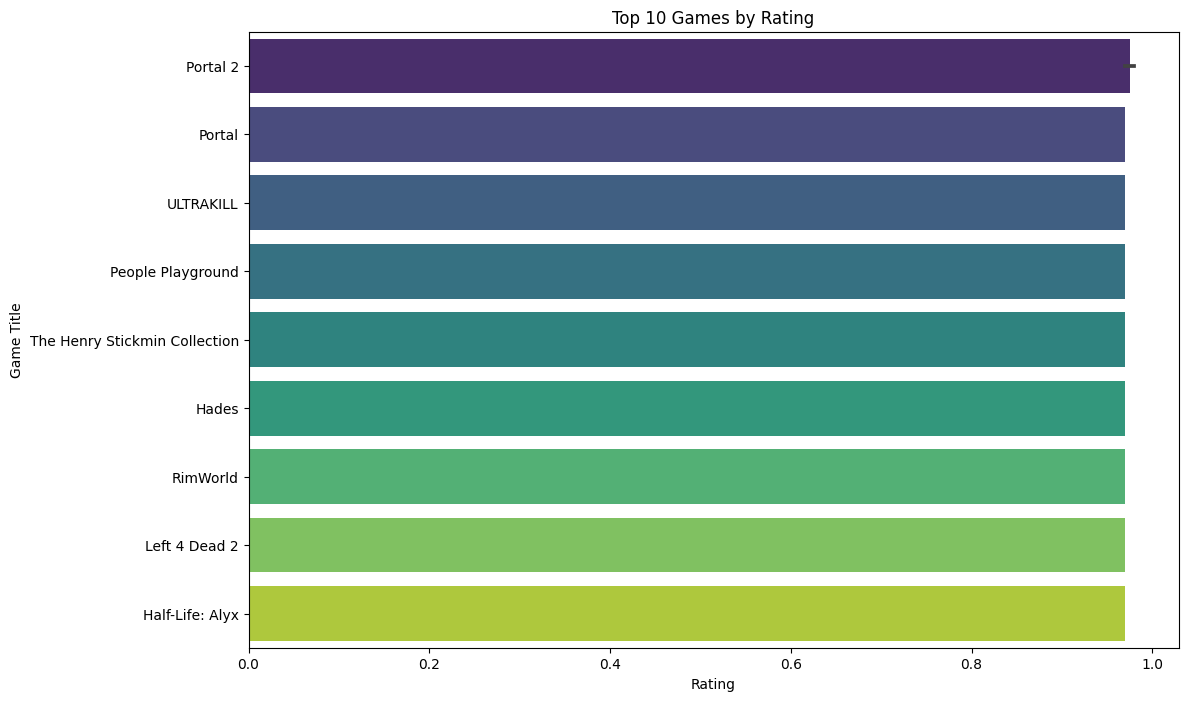

In [202]:
top_games = df.nlargest(10, 'Rating')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_games, x='Rating', y='Name', palette='viridis')
plt.title('Top 10 Games by Rating')
plt.xlabel('Rating')
plt.ylabel('Game Title')
plt.show()

## **Release Date**

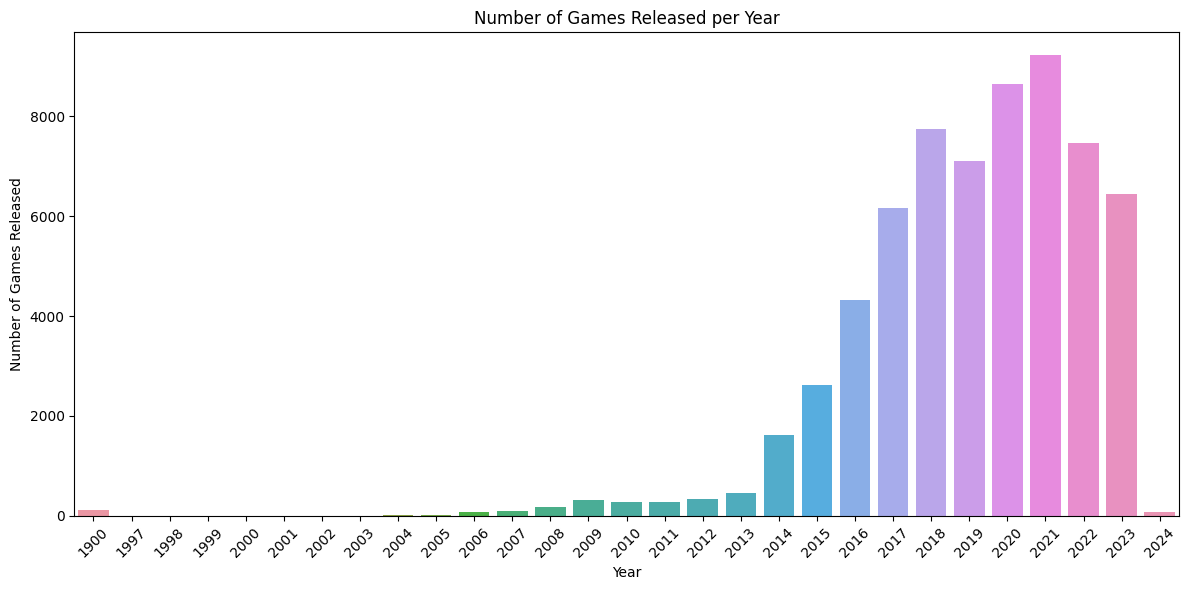

In [203]:
# Calculate the number of games released in each year
games_per_year = df['Year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=games_per_year.index, y=games_per_year.values)
plt.title('Number of Games Released per Year')
plt.xlabel('Year')
plt.ylabel('Number of Games Released')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Price**

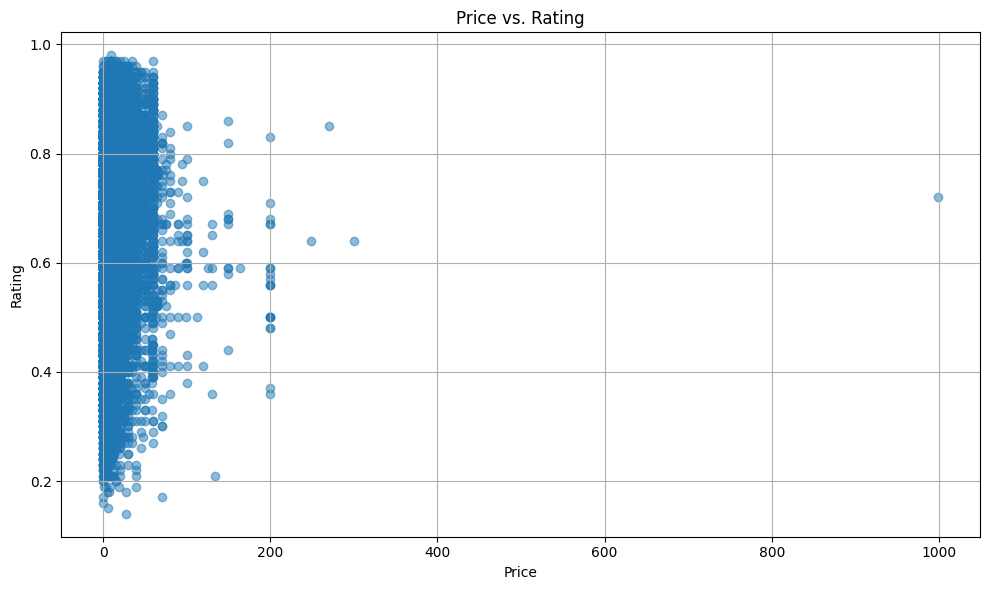

In [204]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Price'], df['Rating'], alpha=0.5)
plt.title('Price vs. Rating')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

## **Supported languages**

In [205]:
support_language_dummy.head()

,AppID,Rating,Sub_English,Sub_French,Sub_Italian,Sub_German,Sub_Spanish-Spain,Sub_Japanese,Sub_Portuguese-Brazil,Sub_Russian,Sub_SimplifiedChinese,Sub_TraditionalChinese,Sub_Korean,Sub_Portuguese,Sub_Danish,Sub_Polish,Sub_Turkish,Sub_Czech,Sub_Hungarian,Sub_Dutch,Sub_Ukrainian,Sub_Spanish-LatinAmerica,Sub_Arabic,Sub_Norwegian,Sub_Romanian,Sub_Swedish,Sub_Thai,Sub_Vietnamese,Sub_Finnish,Sub_Bulgarian,Sub_Greek,Sub_German;,Sub_English(fullaudio),Sub_Slovakian,Sub_Portuguese-Portugal,Sub_Indonesian,Sub_Hebrew,Sub_Lithuanian,Sub_Belarusian,Sub_Irish,Sub_Icelandic,Sub_Catalan,Sub_Latvian,Sub_Serbian,Sub_Croatian,Sub_Estonian,Sub_Slovak,Sub_Basque,Sub_Hindi,Sub_Bangla,Sub_Malay,Sub_Marathi,Sub_Scots,Sub_Filipino,Sub_Persian,Sub_Uzbek,Sub_Urdu,Sub_Armenian,Sub_Igbo,Sub_Sindhi,Sub_Sinhala,Sub_Cherokee,Sub_Galician,Sub_Afrikaans,Sub_Kannada,Sub_Luxembourgish,Sub_Gujarati,Sub_Kyrgyz,Sub_Kazakh,Sub_Turkmen,Sub_Kiche,Sub_Kinyarwanda,Sub_Tajik,Sub_Odia,Sub_Welsh,Sub_Konkani,Sub_Nepali,Sub_Tigrinya,Sub_Slovenian,Sub_Swahili,Sub_Punjabi(Gurmukhi),Sub_Punjabi(Shahmukhi),Sub_Georgian,Sub_Maori,Sub_Wolof,Sub_Bosnian,Sub_Telugu,Sub_Tamil,Sub_Valencian,Sub_Quechua,Sub_Zulu,Sub_Xhosa,Sub_Sotho,Sub_Sorani,Sub_Yoruba,Sub_Uyghur,Sub_Tswana,Sub_Mongolian,Sub_Hausa,Sub_Dari,Sub_Azerbaijani,Sub_Amharic,Sub_Albanian,Sub_Assamese,Sub_Tatar,Sub_Macedonian,Sub_Malayalam,Sub_Maltese,Sub_Khmer
0,20200,0.41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,655370,0.79,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1355720,0.67,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1139950,0.76,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1469160,0.61,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


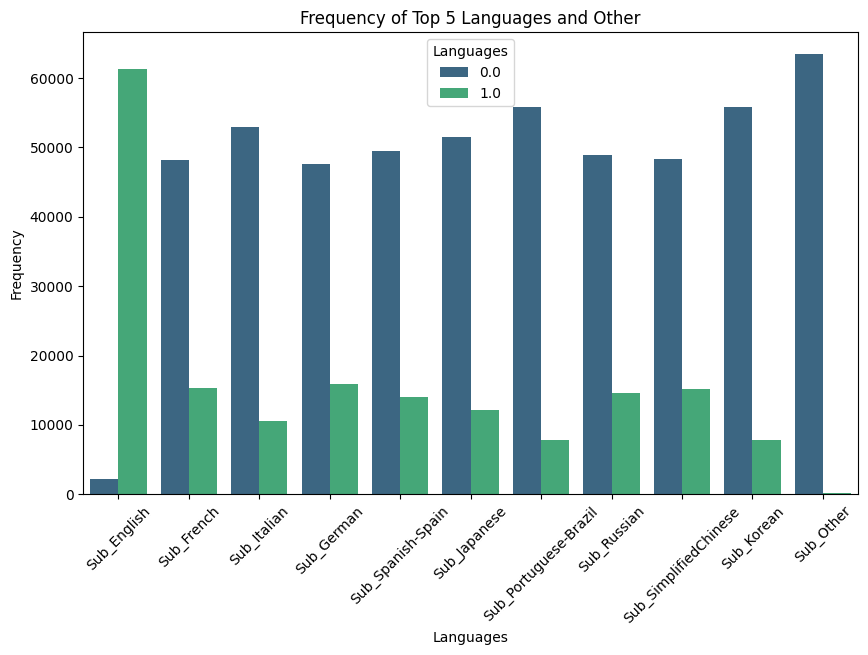

In [206]:
support_language_columns = [col for col in support_language_dummy.columns if col.startswith('Sub_')]
support_language_frequency = support_language_dummy[support_language_columns].sum().sort_values(ascending=False)

# Select top 10 most frequent languages
top_10_support_language =support_language_frequency.head(10).index.tolist()

# Create 'Sub_Other' column and set it to True for games supporting other languages
support_language_dummy['Sub_Other'] = support_language_dummy[support_language_columns].apply(lambda row: not any(row[top] for top in top_10_support_language), axis=1)

# Filter the DataFrame to include the 'AppID', 'Rating', top 10 languages, and 'Sub_Other'
support_language_columns_to_keep = ['AppID', 'Rating'] + [col for col in support_language_columns if col in top_10_support_language] + ['Sub_Other']
support_language_dummy = support_language_dummy[support_language_columns_to_keep]

# Melt the DataFrame to long format for Seaborn plotting
support_language_melted = support_language_dummy.melt(id_vars=['AppID', 'Rating'], var_name='Language', value_name='Support')

# Plot the bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=support_language_melted, x='Language', hue='Support', palette='viridis')
plt.title('Frequency of Top 5 Languages and Other')
plt.xlabel('Languages')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Languages')
plt.show()

In [207]:
support_language_dummy['Sub_Other'] = support_language_dummy['Sub_Other'].astype(int)
support_language_dummy

,AppID,Rating,Sub_English,Sub_French,Sub_Italian,Sub_German,Sub_Spanish-Spain,Sub_Japanese,Sub_Portuguese-Brazil,Sub_Russian,Sub_SimplifiedChinese,Sub_Korean,Sub_Other
0,20200,0.41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,655370,0.79,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0
2,1355720,0.67,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0
3,1139950,0.76,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,1469160,0.61,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63549,2704060,0.50,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0
63550,2645600,0.40,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0
63551,2464700,0.52,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
63552,2602790,0.56,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [208]:
Processed_support_language = process_columns_with_prefix(support_language_dummy, 'Sub_')

In [209]:
Processed_support_language.head(5)

,AppID,Rating,Sub_combined_list,Sub_concentration_points
0,20200,0.41,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
1,655370,0.79,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.818182
2,1355720,0.67,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.818182
3,1139950,0.76,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.181818
4,1469160,0.61,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909


## **Audio Language**

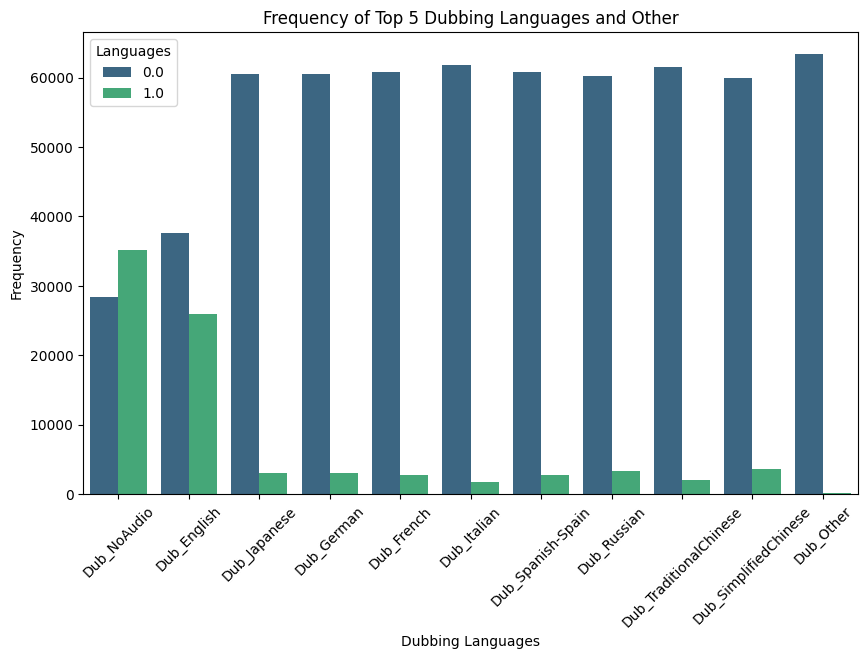

In [210]:
audio_language_columns = [col for col in audio_language_dummy.columns if col.startswith('Dub_')]
audio_language_frequency = audio_language_dummy[audio_language_columns].sum().sort_values(ascending=False)

# Select top 10 most frequent languages
top_10_audio_language = audio_language_frequency.head(10).index.tolist()

# Create 'Dubbing_Other' column and set it to True for games with dubbing languages other than the top 10
audio_language_dummy['Dub_Other'] = audio_language_dummy[audio_language_columns].apply(lambda row: not any(row[top] for top in top_10_audio_language), axis=1)

# Filter the DataFrame to include the 'AppID', 'Rating', top 10 languages, and 'Dub_Other'
audio_language_columns_to_keep = ['AppID', 'Rating'] + [col for col in audio_language_columns if col in top_10_audio_language] + ['Dub_Other']
audio_language_dummy = audio_language_dummy[audio_language_columns_to_keep]

# Melt the DataFrame to long format for Seaborn plotting
audio_language_melted = audio_language_dummy.melt(id_vars=['AppID', 'Rating'], var_name='Language', value_name='Support')

# Plot the bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=audio_language_melted, x='Language', hue='Support', palette='viridis')
plt.title('Frequency of Top 5 Dubbing Languages and Other')
plt.xlabel('Dubbing Languages')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Languages')
plt.show()

In [211]:
audio_language_dummy['Dub_Other'] = audio_language_dummy['Dub_Other'].astype(int)
audio_language_dummy

,AppID,Rating,Dub_NoAudio,Dub_English,Dub_Japanese,Dub_German,Dub_French,Dub_Italian,Dub_Spanish-Spain,Dub_Russian,Dub_TraditionalChinese,Dub_SimplifiedChinese,Dub_Other
0,20200,0.41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,655370,0.79,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1355720,0.67,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1139950,0.76,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1469160,0.61,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63549,2704060,0.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
63550,2645600,0.40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
63551,2464700,0.52,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
63552,2602790,0.56,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [212]:
Processed_audio_language= process_columns_with_prefix(audio_language_dummy, 'Dub_')

In [213]:
Processed_audio_language

,AppID,Rating,Dub_combined_list,Dub_concentration_points
0,20200,0.41,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
1,655370,0.79,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
2,1355720,0.67,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
3,1139950,0.76,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
4,1469160,0.61,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
...,...,...,...,...
63549,2704060,0.50,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
63550,2645600,0.40,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.181818
63551,2464700,0.52,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
63552,2602790,0.56,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909


## **Platform**

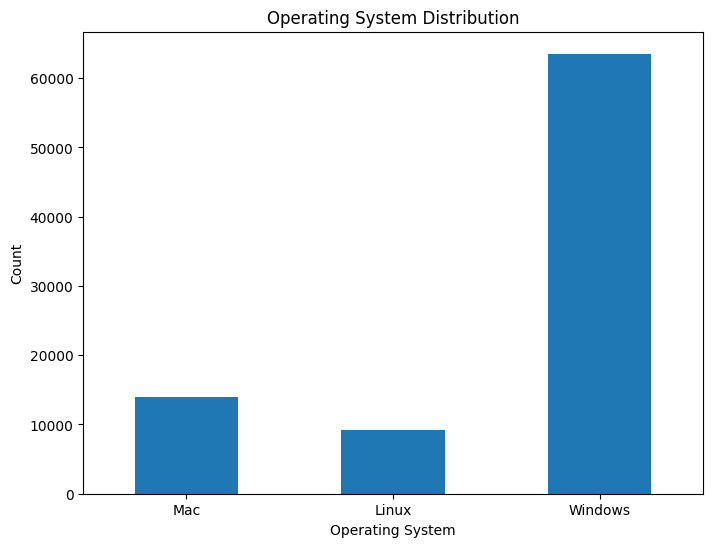

In [214]:
# Calculate the sum of values in the 'Mac', 'Linux', and 'Windows' 
os_counts = df[['Mac', 'Linux', 'Windows']].sum()

plt.figure(figsize=(8, 6))
os_counts.plot(kind='bar')
plt.title('Operating System Distribution')
plt.xlabel('Operating System')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## **Developer**

In [215]:
data_developer.head()

,AppID,Rating,Developer_!CyberApex (SkagoGames),Developer_#12,Developer_#NVJOB,Developer_#workshop,Developer_'Kill On Sight' Game development,Developer_'What Day is it?' Games,Developer_((no-end-parens Studio,Developer_(STCG) Smoker The Car Game,Developer_+7 Software,"Developer_+Mpact Games, LLC.",Developer_+Umbrella,Developer_---,Developer_-Yodasaurus- Games,Developer_-乌鸦男-,Developer_.,Developer_.Cat,Developer_.M.Y.W.,Developer_.ToNg,Developer_.ez Games,Developer_//commentout,Developer_0 Deer Soft,Developer_0-Game Studios,Developer_001,Developer_007berd,Developer_01 Games,Developer_011 Games,Developer_021Workshop,Developer_02GAMES,Developer_07th Expansion,Developer_08 Games,"Developer_0Bennyman,srslyCASUAL",Developer_0Cube,Developer_0Dark&Nerdy,Developer_0_stamina,Developer_0o0,Developer_0x3,Developer_1 Flame Studio,Developer_1-reality,Developer_1.5 hp games,Developer_1/13s,Developer_1/2ofOctahedron,Developer_10 Chambers,Developer_10-2 Knees,Developer_100 Plus Games llc,Developer_100 Stones Interactive,Developer_1000-REKA,Developer_1001 Studio,Developer_100Hr Games,Developer_10101 Software,Developer_1013133 Simulations,Developer_1047 Games,Developer_1081GAMES,Developer_109 Below,Developer_10F,Developer_10Space,Developer_10ft Games,Developer_10ravens s.r.o.,"Developer_10th Art Studio,Daring Touch",Developer_10tons Ltd,Developer_10x10 Room,Developer_11 bit studios,Developer_111144447777a,Developer_11PLANNING,Developer_11Sheep,Developer_12 East Games,Developer_12 Hit Combo,Developer_12 to 6 Studios LLC,Developer_123,Developer_123工作室,Developer_125,Developer_12B3,Developer_12atan,Developer_12x1 Doze Por Um Studio,Developer_13-lab,Developer_1336 Studios,Developer_1337 & Senri AB,Developer_1337 Game Design,Developer_13AM Games,"Developer_13AM Games,WayForward",Developer_13TH Division,Developer_14 Dimension Enterprise,Developer_14 Hours Productions,Developer_14Dimension Enterprise,Developer_14° East,Developer_15 min or less inc,Developer_1564 Studio,"Developer_16 Bit Psych,Kyle B",Developer_16 Swans,Developer_16air,Developer_16bit Nights,Developer_16bitarena.com,Developer_17-BIT,Developer_171Dev,Developer_17Studio,Developer_17windy,Developer_1812 Productions (PC Port),Developer_1888 Games,Developer_18Light Game Ltd.,"Developer_18Light Game Ltd.,FunZone Games",Developer_1917 Studios,Developer_1939 Games,Developer_1984pxls,Developer_1986 CL3,Developer_199 Cents STUDIO,Developer_199CentsSTUDIO,Developer_1BITDRAGON,Developer_1C Game Studios,Developer_1C Wireless,Developer_1C-Avalon,Developer_1C: Maddox Games,Developer_1C:InoCo,Developer_1CC Games,Developer_1DER Entertainment,Developer_1M Bits Horde,Developer_1MP,Developer_1Monkey2Brains,Developer_1P2P,Developer_1PXL Games,Developer_1SiGn Games,Developer_1TonSkeleton,Developer_1UP Factory,Developer_1UP Games,Developer_1UP games,Developer_1actose,Developer_1bgame,Developer_1bit,Developer_1bit Games,Developer_1classydude,Developer_1f1n1ty,Developer_1ming益铭,Developer_1scGames,Developer_1st impact games,"Developer_1up Indie,Gutpunch Studios","Developer_1up Indie,Leo Dawn",Developer_2 Barrel Arts,Developer_2 Bears Studio,Developer_2 Bit Determine,Developer_2 Cubs Studio,Developer_2 Devi LLC,Developer_2 FOR 2,Developer_2 Hit Studio,Developer_2 Monkeys,Developer_2 Stupid Devs,Developer_2 Ton Studios,Developer_2 Zombie Games,Developer_2 players,"Developer_2,000 Damage",Developer_2-Volt Games,Developer_2.0 Studios,Developer_20 Credit Studios,Developer_20 Watt Games,Developer_2015,Developer_202-N Studios,Developer_2020 Venture,Developer_2049VR,Developer_2054,Developer_20letpast,"Developer_21c.Ducks Co., Ltd.",Developer_221 Games,Developer_226GameStudio,Developer_229Production,Developer_22cans,Developer_23:23 Team,Developer_24 Caret Games,Developer_24 Entertainment,"Developer_24Frame,inc.",Developer_251 Games,Developer_2645Interactive,Developer_269th lab games softworks,Developer_26PM,Developer_26horses,Developer_26k,Developer_275,Developer_286studio,Developer_29x,"Developer_2>,Dexter.CO",Developer_

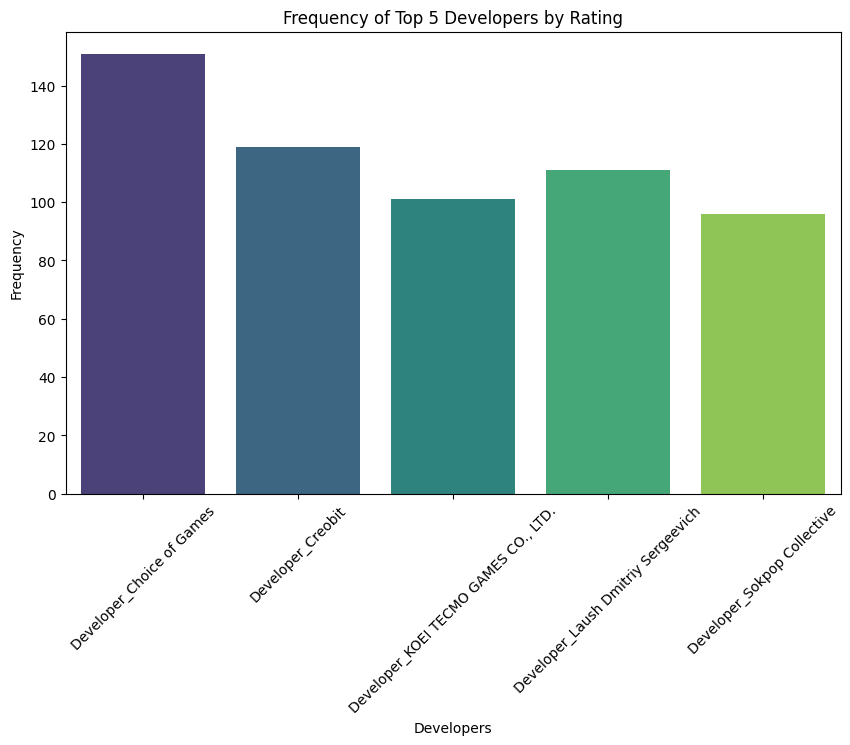

In [216]:
# Calculate the sum of ratings for each developer
developer_columns = [col for col in data_developer.columns if col.startswith('Developer_')]
developer_rating_sum = data_developer[developer_columns].sum().sort_values(ascending=False)

# Select the top 5 developers based on the sum of ratings
top_5_developers = developer_rating_sum.head(5).index.tolist()

# Create 'Developer_Other' column and set it to True for games developed by others
data_developer['Developer_Other'] = data_developer[developer_columns].apply(lambda row: not any(row[top] for top in top_5_developers), axis=1)

# Keep the 'AppID' and 'Rating' columns intact
data_developer_columns_to_keep = ['AppID', 'Rating'] + [col for col in developer_columns if col in top_5_developers] + ['Developer_Other']
data_developer = data_developer[data_developer_columns_to_keep]

# Filter out rows where 'Developer_Other' is True
filtered_data_developer = data_developer[data_developer['Developer_Other'] == False]

# Melt the DataFrame to long format for Seaborn plotting, excluding 'Developer_Other'
filtered_data_developer_melted = filtered_data_developer.melt(id_vars=['AppID', 'Rating'], var_name='Developer', value_name='Support')

# Only include rows where 'Support' is True
filtered_data_melted = filtered_data_developer_melted[filtered_data_developer_melted['Support']]

# Plot the bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_data_melted, x='Developer', palette='viridis')
plt.title('Frequency of Top 5 Developers by Rating')
plt.xlabel('Developers')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [217]:
data_developer.head()

,AppID,Rating,Developer_Choice of Games,Developer_Creobit,"Developer_KOEI TECMO GAMES CO., LTD.",Developer_Laush Dmitriy Sergeevich,Developer_Sokpop Collective,Developer_Other
0,20200,0.41,False,False,False,False,False,True
1,655370,0.79,False,False,False,False,False,True
3,1355720,0.67,False,False,False,False,False,True
4,1139950,0.76,False,False,False,False,False,True
5,1469160,0.61,False,False,False,False,False,True


## **Publisher**

In [218]:
data_publisher.head()

,AppID,Rating,Publisher_'Kill On Sight' Game Development,Publisher_((no-end-parens Studio,Publisher_(Myco),Publisher_(STCG) Smoker The Car Game,Publisher_(none),"Publisher_++Good Games,GameChanger Charity",Publisher_+7 Software,"Publisher_+Mpact Games, LLC.",Publisher_+Umbrella,Publisher_-,Publisher_--,Publisher_---,Publisher_-In.,Publisher_-Yodasaurus- Games,Publisher_-乌鸦男-,Publisher_.,Publisher_...,Publisher_.Cat,Publisher_.M.Y.W.,Publisher_.ToNg,Publisher_.ez Games,Publisher_0 Deer Soft Partnership,Publisher_0-Game Studios,Publisher_001,Publisher_007berd,Publisher_011 Games,Publisher_021Workshop,Publisher_02GAMES,Publisher_0Cube,Publisher_0Dark&Nerdy,Publisher_0UP GAMES,Publisher_0_stamina,Publisher_0o0,Publisher_1 Flame Studio,"Publisher_1 Trait Danger,Matador Records",Publisher_1-reality,Publisher_1.5 hp games,Publisher_1/13s,Publisher_1/2ofOctahedron,Publisher_10 Chambers,Publisher_10-2 Knees,"Publisher_100 GAMES,Gamersky Games",Publisher_100 Plus Games llc,Publisher_100 Stones Interactive,"Publisher_1000-REKA,mirai works",Publisher_1001 Studio,Publisher_100Hr Games,Publisher_10101 Software,Publisher_1013133 Simulations,Publisher_101XP,Publisher_1047 Games,Publisher_1081GAMES,Publisher_109 Below,Publisher_10F,Publisher_10Space,Publisher_10ft Games,Publisher_10mg,"Publisher_10mg,Gesinimo Games",Publisher_10ravens s.r.o.,Publisher_10th Reality,Publisher_10tons Ltd,Publisher_10x10 Room,Publisher_11 bit studios,Publisher_11/10 games,Publisher_110 Industries SA,Publisher_111144447777a,Publisher_11PLANNING,Publisher_11Sheep,Publisher_12 East Games,Publisher_12 to 6 Studios LLC,Publisher_123,Publisher_123工作室,Publisher_12B3,"Publisher_13-lab,azimut team","Publisher_13-lab,azimuth team",Publisher_1336 Studios,Publisher_1337 Game Design,Publisher_13AM Games,"Publisher_13AM Shipping Solutions,13AM Games",Publisher_13TH Division,Publisher_14 Dimension Enterprise,Publisher_14 Hours Productions,Publisher_14BitsStudio,Publisher_14Dimension Enterprise,Publisher_1564 Studio,Publisher_16 Swans,Publisher_16air,Publisher_16bitarena.com,Publisher_17-BIT,Publisher_171Dev,Publisher_17Studio,Publisher_17windy,Publisher_1812 Productions,"Publisher_18Light Game Ltd.,CE-Asia,樂磚 Joy Brick,Mayflower Entertainment","Publisher_18Light Game Ltd.,Cheese Games",Publisher_1917 Studios,Publisher_1939 Games,Publisher_1984pxls,Publisher_1986 CL3,Publisher_199 CENTS STUDIO,Publisher_199 Cents STUDIO,Publisher_1999UEM,Publisher_199CentsSTUDIO,Publisher_1BITDRAGON,Publisher_1C Company,Publisher_1C Entertainment,Publisher_1C Game Studios,Publisher_1C Online Games,Publisher_1C-SoftClub,Publisher_1DER Entertainment,Publisher_1MP,Publisher_1Monkey2Brains,Publisher_1SiGn Games,Publisher_1TonSkeleton,Publisher_1UP Factory,Publisher_1UP Games,Publisher_1UP games,Publisher_1actose,Publisher_1bgame,Publisher_1bit,Publisher_1bit Games,Publisher_1classydude,Publisher_1ming益铭,Publisher_1st impact games,Publisher_1up Indie,Publisher_2 Bad Design,Publisher_2 Barrel Arts,Publisher_2 Bit Determine,Publisher_2 Cubs Studio,Publisher_2 Devi LLC,Publisher_2 FOR 2,Publisher_2 Hit Studio,Publisher_2 Left Thumbs,Publisher_2 Zombie Games,Publisher_2&30 Software,Publisher_2-Volt Games,Publisher_2.0 Studios,Publisher_20 Credit Studios,Publisher_20 Watt Games,Publisher_202-N Studios,Publisher_2020 Venture,Publisher_2049VR,Publisher_2054,Publisher_207 Studios,Publisher_20Tab,Publisher_20letpast,Publisher_20th Century Fox Film Corporation,Publisher_2124 Publishing,Publisher_221 Games,Publisher_226GameStudio,Publisher_229Production,Publisher_22cans,Publisher_23:23 Team,Publisher_24 Caret Games,"Publisher_24Frame,inc.",Publisher_255pixel Studios,Publisher_2645Interactive,Publisher_269th lab games softworks,Publisher_26PM,Publisher_26horses,Publisher_26k,Publisher_286studio,Publisher_29x,Publisher_2:30 AM Studios,"Publisher_2>,Dexter.CO",Publisher_2AM(熬夜工作室),Publisher_2Awesome Studio,Publisher_2BDev,Publisher_2B_GAMES,Publisher_2Beats,Publisher_2Bit Studios,Publisher_2Blocks,Publisher_2Boone 

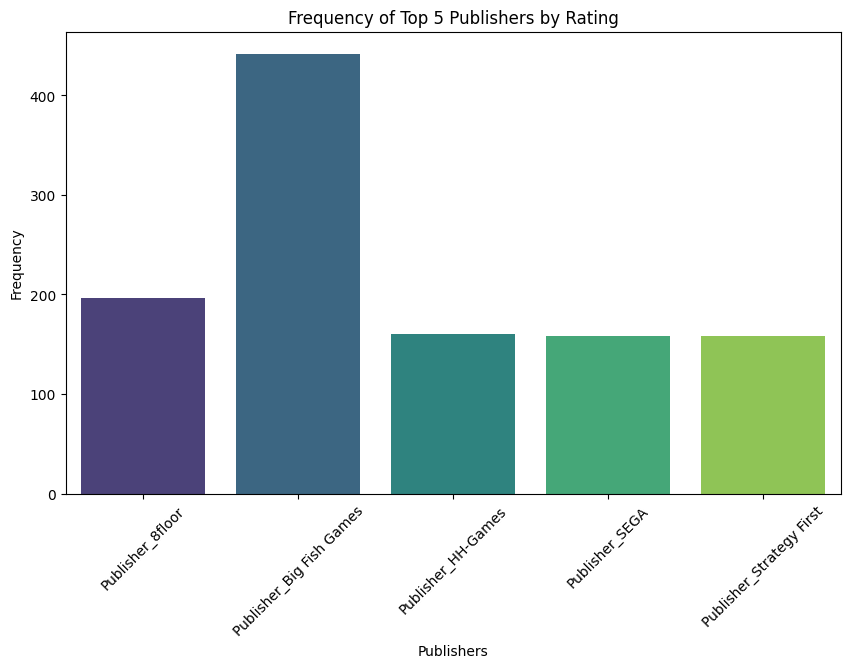

In [219]:
# Calculate the sum of ratings for each publisher
publisher_columns = [col for col in data_publisher.columns if col.startswith('Publisher_')]
publisher_rating_sum = data_publisher[publisher_columns].sum().sort_values(ascending=False)

# Select the top 5 publishers based on the sum of ratings
top_5_publishers = publisher_rating_sum.head(5).index.tolist()

# Create 'Publisher_Other' column and set it to True for games published by others
data_publisher['Publisher_Other'] = data_publisher[publisher_columns].apply(lambda row: not any(row[top] for top in top_5_publishers), axis=1)

# Keep the 'AppID' and 'Rating' columns intact
data_publisher_columns_to_keep = ['AppID', 'Rating'] + [col for col in publisher_columns if col in top_5_publishers] + ['Publisher_Other']
data_publisher = data_publisher[data_publisher_columns_to_keep]

# Filter out rows where 'Publisher_Other' is True
filtered_data_publisher = data_publisher[data_publisher['Publisher_Other'] == False]

# Melt the DataFrame to long format for Seaborn plotting, excluding 'Publisher_Other'
filtered_data_publisher_melted = filtered_data_publisher.melt(id_vars=['AppID', 'Rating'], var_name='Publisher', value_name='Support')

# Only include rows where 'Support' is True
filtered_data_publisher_melted = filtered_data_publisher_melted[filtered_data_publisher_melted['Support']]

# Plot the bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_data_publisher_melted, x='Publisher', palette='viridis')
plt.title('Frequency of Top 5 Publishers by Rating')
plt.xlabel('Publishers')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [220]:
data_publisher.head()

,AppID,Rating,Publisher_8floor,Publisher_Big Fish Games,Publisher_HH-Games,Publisher_SEGA,Publisher_Strategy First,Publisher_Other
0,20200,0.41,False,False,False,False,False,True
1,655370,0.79,False,False,False,False,False,True
3,1355720,0.67,False,False,False,False,False,True
4,1139950,0.76,False,False,False,False,False,True
5,1469160,0.61,False,False,False,False,False,True


## **Genres**

In [221]:
data_genre = data_genre.drop(columns=['combined_list', 'concentration_points'])
data_genre.head()

,AppID,Rating,Genre_Free to Play,Genre_Early Access,Genre_Action,Genre_Adventure,Genre_Casual,Genre_Indie,Genre_Massively Multiplayer,Genre_Racing,Genre_RPG,Genre_Simulation,Genre_Sports,Genre_Strategy
0,20200,0.41,0,0,0,0,1,1,0,0,0,0,1,0
1,655370,0.79,0,0,1,0,0,1,0,0,0,0,0,0
3,1355720,0.67,0,0,0,1,1,1,0,0,0,0,0,0
4,1139950,0.76,0,0,0,1,0,1,0,0,0,0,0,0
5,1469160,0.61,1,0,0,1,1,0,1,0,1,0,0,1


In [222]:
data_genre_temp = data_genre.drop(columns='AppID').copy()
data_genre_temp.columns

Index(['Rating', 'Genre_Free to Play', 'Genre_Early Access', 'Genre_Action',
       'Genre_Adventure', 'Genre_Casual', 'Genre_Indie',
       'Genre_Massively Multiplayer', 'Genre_Racing', 'Genre_RPG',
       'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy'],
      dtype='object')

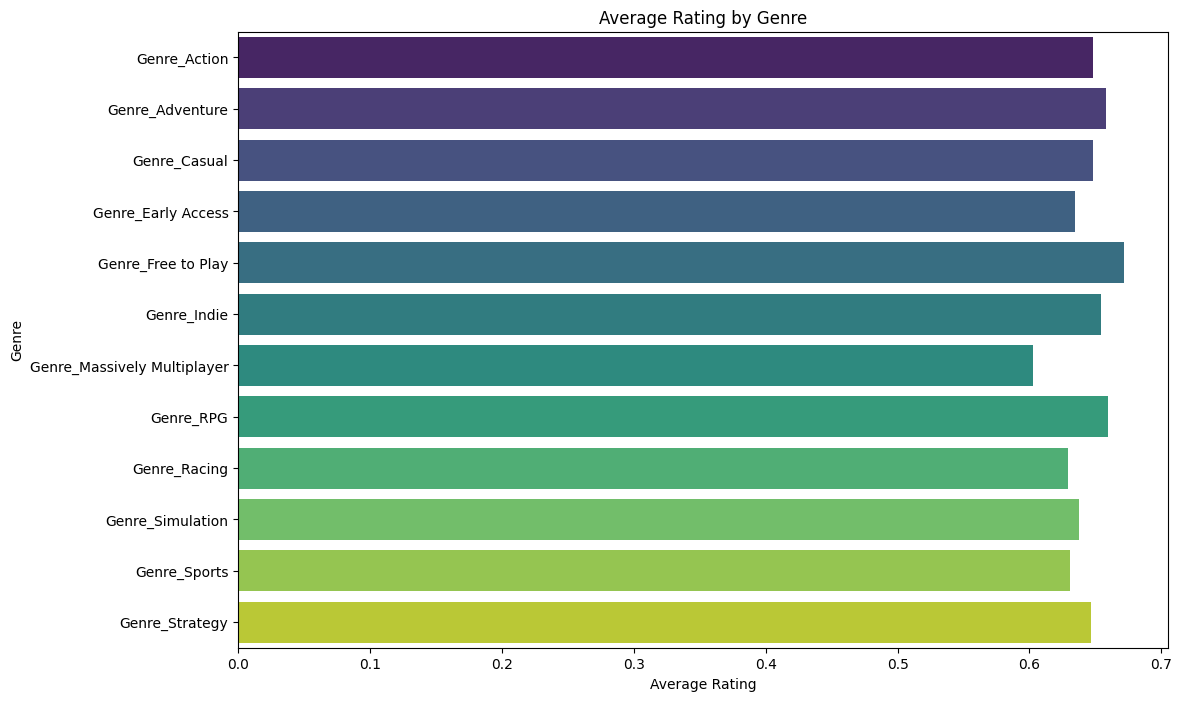

In [223]:
data_genre_long = data_genre_temp.melt(id_vars=['Rating'], 
                                       var_name='Genre', 
                                       value_name='Value')

# Filter out rows where Value is 0 (not of that genre)
data_genre_long = data_genre_long[data_genre_long['Value'] == 1]

# Group by Genre and calculate the mean rating
genre_ratings = data_genre_long.groupby('Genre')['Rating'].mean().reset_index()

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(data=genre_ratings, x='Rating', y='Genre', palette='viridis')
plt.title('Average Rating by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

----
# **Combine The Data**

In [224]:
pegi_dummy

,AppID,PEGI_3,PEGI_7,PEGI_12,PEGI_16,PEGI_18
0,20200,1,0,0,0,0
1,655370,1,0,0,0,0
3,1355720,1,0,0,0,0
4,1139950,1,0,0,0,0
5,1469160,1,0,0,0,0
...,...,...,...,...,...,...
85077,2704060,1,0,0,0,0
85079,2645600,1,0,0,0,0
85083,2464700,1,0,0,0,0
85085,2602790,1,0,0,0,0


In [225]:
Processed_support_language

,AppID,Rating,Sub_combined_list,Sub_concentration_points
0,20200,0.41,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
1,655370,0.79,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.818182
2,1355720,0.67,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.818182
3,1139950,0.76,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.181818
4,1469160,0.61,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
...,...,...,...,...
63549,2704060,0.50,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",0.545455
63550,2645600,0.40,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.818182
63551,2464700,0.52,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.181818
63552,2602790,0.56,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.181818


In [226]:
Processed_audio_language

,AppID,Rating,Dub_combined_list,Dub_concentration_points
0,20200,0.41,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
1,655370,0.79,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
2,1355720,0.67,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
3,1139950,0.76,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
4,1469160,0.61,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
...,...,...,...,...
63549,2704060,0.50,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
63550,2645600,0.40,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.181818
63551,2464700,0.52,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909
63552,2602790,0.56,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.090909


In [227]:
Processed_genre

,AppID,Rating,Genre_combined_list,Genre_concentration_points
0,20200,0.41,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]",0.250000
1,655370,0.79,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]",0.166667
3,1355720,0.67,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]",0.250000
4,1139950,0.76,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]",0.166667
5,1469160,0.61,"[1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]",0.500000
...,...,...,...,...
85077,2704060,0.50,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]",0.333333
85079,2645600,0.40,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]",0.250000
85083,2464700,0.52,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]",0.250000
85085,2602790,0.56,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]",0.166667


In [228]:
Processed_platform

,AppID,Rating,Platform_combined_list,Platform_concentration_points
0,20200,0.41,"[1, 0, 0]",0.333333
1,655370,0.79,"[1, 0, 1]",0.666667
3,1355720,0.67,"[1, 1, 1]",1.000000
4,1139950,0.76,"[1, 0, 1]",0.666667
5,1469160,0.61,"[1, 0, 0]",0.333333
...,...,...,...,...
85077,2704060,0.50,"[1, 0, 0]",0.333333
85079,2645600,0.40,"[1, 0, 1]",0.666667
85083,2464700,0.52,"[1, 0, 0]",0.333333
85085,2602790,0.56,"[1, 0, 0]",0.333333


In [229]:
df = df.drop(columns=['Windows', 'Mac', 'Linux'], axis=1)

In [230]:
# Combine all data into 'df'
df = pd.merge(df, pegi_dummy, on="AppID")
df = pd.merge(df, Processed_support_language[['AppID', 'Sub_concentration_points']], on="AppID")
df = pd.merge(df, Processed_audio_language[['AppID', 'Dub_concentration_points']], on="AppID")
df = pd.merge(df, Processed_platform[['AppID', 'Platform_concentration_points']], on="AppID")
df = pd.merge(df, Processed_genre[['AppID', 'Genre_concentration_points']], on="AppID")

In [231]:
# Reset 'df' index 
df = df.reset_index().drop(columns=['index', 'Name', 'AppID'], axis=1)

In [232]:
df.head()

,Price,Rating,Year,Quarter,Month,Day,PEGI_3,PEGI_7,PEGI_12,PEGI_16,PEGI_18,Sub_concentration_points,Dub_concentration_points,Platform_concentration_points,Genre_concentration_points
0,19.99,0.41,2008,4,10,21,1,0,0,0,0,0.090909,0.090909,0.333333,0.250000
1,0.99,0.79,2017,4,10,12,1,0,0,0,0,0.818182,0.090909,0.666667,0.166667
2,5.99,0.67,2020,3,7,23,1,0,0,0,0,0.818182,0.090909,1.000000,0.250000
3,0.00,0.76,2020,1,2,3,1,0,0,0,0,0.181818,0.090909,0.666667,0.166667
4,0.00,0.61,2021,1,2,26,1,0,0,0,0,0.090909,0.090909,0.333333,0.500000


In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63554 entries, 0 to 63553
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Price                          63554 non-null  float64
 1   Rating                         63554 non-null  float64
 2   Year                           63554 non-null  int32  
 3   Quarter                        63554 non-null  int32  
 4   Month                          63554 non-null  int32  
 5   Day                            63554 non-null  int32  
 6   PEGI_3                         63554 non-null  int32  
 7   PEGI_7                         63554 non-null  int32  
 8   PEGI_12                        63554 non-null  int32  
 9   PEGI_16                        63554 non-null  int32  
 10  PEGI_18                        63554 non-null  int32  
 11  Sub_concentration_points       63554 non-null  float64
 12  Dub_concentration_points       63554 non-null 

In [234]:
df.isna().sum()

Price                            0
Rating                           0
Year                             0
Quarter                          0
Month                            0
Day                              0
PEGI_3                           0
PEGI_7                           0
PEGI_12                          0
PEGI_16                          0
PEGI_18                          0
Sub_concentration_points         0
Dub_concentration_points         0
Platform_concentration_points    0
Genre_concentration_points       0
dtype: int64

---
# **Check Outlier**

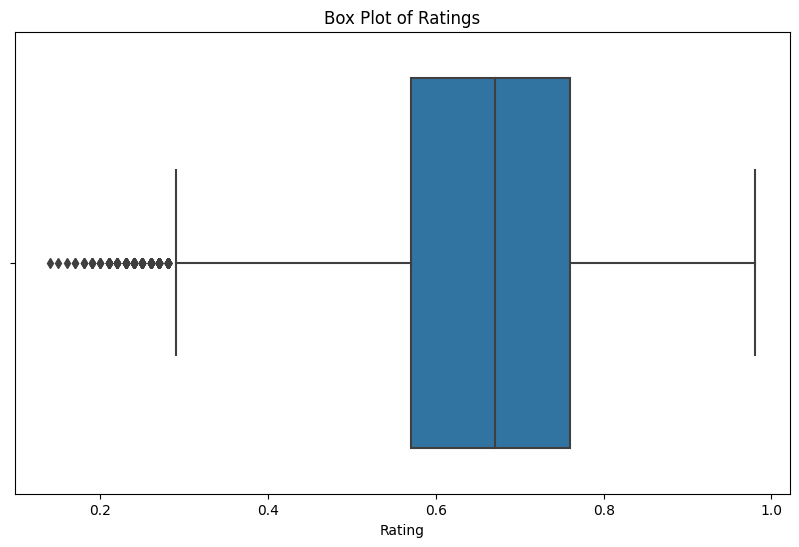

In [235]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Rating'])
plt.title('Box Plot of Ratings')
plt.xlabel('Rating')
plt.show()

In [236]:
df = remove_outliers(df, ['Rating'])

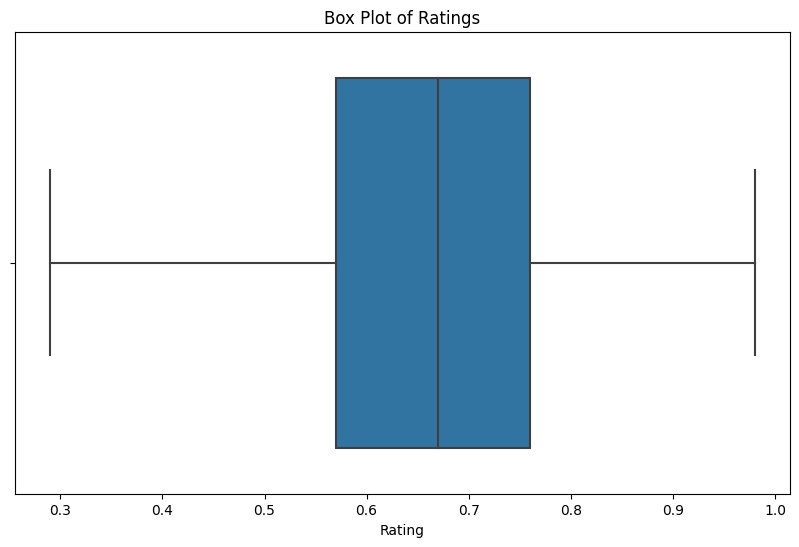

In [237]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Rating'])
plt.title('Box Plot of Ratings')
plt.xlabel('Rating')
plt.show()

----
# **Turn into classification problem**

In [238]:
def assign_tier(rating):
    if rating <= 3.4:
        return 'C'
    elif rating > 3.4 and rating <= 6.0:
        return 'B'
    elif rating > 6.0 and rating <= 8.5:
        return 'A'
    elif rating > 8.5 and rating <= 10.0:
        return 'S'
    else:
        return 'Unknown'

In [239]:
df_class = df.copy()
df_class.head()

,Price,Rating,Year,Quarter,Month,Day,PEGI_3,PEGI_7,PEGI_12,PEGI_16,PEGI_18,Sub_concentration_points,Dub_concentration_points,Platform_concentration_points,Genre_concentration_points
0,19.99,0.41,2008,4,10,21,1,0,0,0,0,0.090909,0.090909,0.333333,0.250000
1,0.99,0.79,2017,4,10,12,1,0,0,0,0,0.818182,0.090909,0.666667,0.166667
2,5.99,0.67,2020,3,7,23,1,0,0,0,0,0.818182,0.090909,1.000000,0.250000
3,0.00,0.76,2020,1,2,3,1,0,0,0,0,0.181818,0.090909,0.666667,0.166667
4,0.00,0.61,2021,1,2,26,1,0,0,0,0,0.090909,0.090909,0.333333,0.500000


In [240]:
df_class['Rating'] = df_class['Rating'] * 10
df_class['Tier'] = df_class['Rating'].apply(assign_tier)
df_class.head()

,Price,Rating,Year,Quarter,Month,Day,PEGI_3,PEGI_7,PEGI_12,PEGI_16,PEGI_18,Sub_concentration_points,Dub_concentration_points,Platform_concentration_points,Genre_concentration_points,Tier
0,19.99,4.1,2008,4,10,21,1,0,0,0,0,0.090909,0.090909,0.333333,0.250000,B
1,0.99,7.9,2017,4,10,12,1,0,0,0,0,0.818182,0.090909,0.666667,0.166667,A
2,5.99,6.7,2020,3,7,23,1,0,0,0,0,0.818182,0.090909,1.000000,0.250000,A
3,0.00,7.6,2020,1,2,3,1,0,0,0,0,0.181818,0.090909,0.666667,0.166667,A
4,0.00,6.1,2021,1,2,26,1,0,0,0,0,0.090909,0.090909,0.333333,0.500000,A


In [241]:
df_class['Tier'].value_counts()

Tier
A    37392
B    21285
S     3743
C      805
Name: count, dtype: int64

In [242]:
df_class = df_class.drop(columns='Rating')

In [243]:
df_class.head()

,Price,Year,Quarter,Month,Day,PEGI_3,PEGI_7,PEGI_12,PEGI_16,PEGI_18,Sub_concentration_points,Dub_concentration_points,Platform_concentration_points,Genre_concentration_points,Tier
0,19.99,2008,4,10,21,1,0,0,0,0,0.090909,0.090909,0.333333,0.250000,B
1,0.99,2017,4,10,12,1,0,0,0,0,0.818182,0.090909,0.666667,0.166667,A
2,5.99,2020,3,7,23,1,0,0,0,0,0.818182,0.090909,1.000000,0.250000,A
3,0.00,2020,1,2,3,1,0,0,0,0,0.181818,0.090909,0.666667,0.166667,A
4,0.00,2021,1,2,26,1,0,0,0,0,0.090909,0.090909,0.333333,0.500000,A


## **Check price column**

In [244]:
highest_price = df_class['Price'].max()
print(highest_price)

999.0


In [245]:
highest_price = df_class['Price'].max()

highest_price_count = df_class['Price'].value_counts()[highest_price]

print(highest_price_count)

1


In [246]:
prices_above_100 = df_class[df_class['Price'] > 100]['Price']

value_counts_above_100 = prices_above_100.value_counts()

print(value_counts_above_100)


Price
199.99    20
149.99    10
129.99     5
119.99     4
249.00     1
999.00     1
269.99     1
124.99     1
299.90     1
164.34     1
111.99     1
Name: count, dtype: int64


In [247]:
highest_price = df_class['Price'].max()
print(highest_price)

999.0


In [248]:
df_class = df_class[df_class['Price'] <= 200]

df_class.reset_index(drop=True, inplace=True)

In [249]:
df_class

,Price,Year,Quarter,Month,Day,PEGI_3,PEGI_7,PEGI_12,PEGI_16,PEGI_18,Sub_concentration_points,Dub_concentration_points,Platform_concentration_points,Genre_concentration_points,Tier
0,19.99,2008,4,10,21,1,0,0,0,0,0.090909,0.090909,0.333333,0.250000,B
1,0.99,2017,4,10,12,1,0,0,0,0,0.818182,0.090909,0.666667,0.166667,A
2,5.99,2020,3,7,23,1,0,0,0,0,0.818182,0.090909,1.000000,0.250000,A
3,0.00,2020,1,2,3,1,0,0,0,0,0.181818,0.090909,0.666667,0.166667,A
4,0.00,2021,1,2,26,1,0,0,0,0,0.090909,0.090909,0.333333,0.500000,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63216,0.99,2024,1,1,5,1,0,0,0,0,0.545455,0.090909,0.333333,0.333333,B
63217,2.99,2024,1,1,5,1,0,0,0,0,0.818182,0.181818,0.666667,0.250000,B
63218,3.74,2024,1,1,5,1,0,0,0,0,0.181818,0.090909,0.333333,0.250000,B
63219,8.49,2024,1,1,5,1,0,0,0,0,0.181818,0.090909,0.333333,0.166667,B


In [250]:
prices_above_100 = df_class[df_class['Price'] > 100]['Price']

value_counts_above_100 = prices_above_100.value_counts()

print(value_counts_above_100)

Price
199.99    20
149.99    10
129.99     5
119.99     4
124.99     1
164.34     1
111.99     1
Name: count, dtype: int64


----
# **Classification Model**

In [251]:
df_class.head()

,Price,Year,Quarter,Month,Day,PEGI_3,PEGI_7,PEGI_12,PEGI_16,PEGI_18,Sub_concentration_points,Dub_concentration_points,Platform_concentration_points,Genre_concentration_points,Tier
0,19.99,2008,4,10,21,1,0,0,0,0,0.090909,0.090909,0.333333,0.250000,B
1,0.99,2017,4,10,12,1,0,0,0,0,0.818182,0.090909,0.666667,0.166667,A
2,5.99,2020,3,7,23,1,0,0,0,0,0.818182,0.090909,1.000000,0.250000,A
3,0.00,2020,1,2,3,1,0,0,0,0,0.181818,0.090909,0.666667,0.166667,A
4,0.00,2021,1,2,26,1,0,0,0,0,0.090909,0.090909,0.333333,0.500000,A


In [252]:
df_class['Tier'].value_counts()

Tier
A    37388
B    21285
S     3743
C      805
Name: count, dtype: int64

In [253]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63221 entries, 0 to 63220
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Price                          63221 non-null  float64
 1   Year                           63221 non-null  int32  
 2   Quarter                        63221 non-null  int32  
 3   Month                          63221 non-null  int32  
 4   Day                            63221 non-null  int32  
 5   PEGI_3                         63221 non-null  int32  
 6   PEGI_7                         63221 non-null  int32  
 7   PEGI_12                        63221 non-null  int32  
 8   PEGI_16                        63221 non-null  int32  
 9   PEGI_18                        63221 non-null  int32  
 10  Sub_concentration_points       63221 non-null  float64
 11  Dub_concentration_points       63221 non-null  float64
 12  Platform_concentration_points  63221 non-null 

In [254]:
X_class = df_class.drop(columns=['Tier'], axis=1).copy()
y_class = df_class['Tier'].copy()

In [255]:
X_class

,Price,Year,Quarter,Month,Day,PEGI_3,PEGI_7,PEGI_12,PEGI_16,PEGI_18,Sub_concentration_points,Dub_concentration_points,Platform_concentration_points,Genre_concentration_points
0,19.99,2008,4,10,21,1,0,0,0,0,0.090909,0.090909,0.333333,0.250000
1,0.99,2017,4,10,12,1,0,0,0,0,0.818182,0.090909,0.666667,0.166667
2,5.99,2020,3,7,23,1,0,0,0,0,0.818182,0.090909,1.000000,0.250000
3,0.00,2020,1,2,3,1,0,0,0,0,0.181818,0.090909,0.666667,0.166667
4,0.00,2021,1,2,26,1,0,0,0,0,0.090909,0.090909,0.333333,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63216,0.99,2024,1,1,5,1,0,0,0,0,0.545455,0.090909,0.333333,0.333333
63217,2.99,2024,1,1,5,1,0,0,0,0,0.818182,0.181818,0.666667,0.250000
63218,3.74,2024,1,1,5,1,0,0,0,0,0.181818,0.090909,0.333333,0.250000
63219,8.49,2024,1,1,5,1,0,0,0,0,0.181818,0.090909,0.333333,0.166667


In [256]:
y_class.value_counts()

Tier
A    37388
B    21285
S     3743
C      805
Name: count, dtype: int64

In [257]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, train_size=0.8011, random_state=42)
X_train_class.shape, X_test_class.shape, y_train_class.shape, y_test_class.shape

((50646, 14), (12575, 14), (50646,), (12575,))

In [258]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

gb_classifier = GradientBoostingClassifier(
    n_estimators=200,            
    learning_rate=0.1,           
    min_samples_split=200,       
    min_samples_leaf=20,         
    max_depth=6,                 
    max_features='sqrt',         
    subsample=0.85,              
    random_state=42,
    validation_fraction=0.1,     
    n_iter_no_change=10,         
    tol=0.0001                   
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', gb_classifier)
])

pipeline.fit(X_train_class, y_train_class)

with open('best_gb_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

y_pred_class = pipeline.predict(X_test_class)

accuracy = accuracy_score(y_test_class, y_pred_class)
report = classification_report(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.6000795228628231
Classification Report:
               precision    recall  f1-score   support

           A       0.61      0.93      0.73      7419
           B       0.53      0.15      0.23      4238
           C       0.50      0.01      0.01       166
           S       0.45      0.05      0.08       752

    accuracy                           0.60     12575
   macro avg       0.52      0.28      0.27     12575
weighted avg       0.57      0.60      0.52     12575

Confusion Matrix:
 [[6880  500    1   38]
 [3604  631    0    3]
 [ 131   34    1    0]
 [ 699   19    0   34]]
